## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


Set seed for reproducability

In [3]:
seed = 1337
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [4]:
def func_VanDerWaals_Oxygen(P_pa,T_celsius):
    import numpy as np
#    import matplotlib.pyplot as plt
    
    # Van Der Waals eqution from "Thermodynamics - An Engineering Approach, Cengel & Boles 2014" Eq 3-22
    # where "a" and "b" are estimated from 3-23
    
    #np.roots([1,1,-2])
    # For Oxygen:
    
#    z=1 # "m"  Depth
#    T1=273+6 # "K" temperature
#    T2=273+12 # "K" temperature
#    T3=273+20 # "K" temperature
    
#    z_vec=np.arange(0,1010,50)
#    
#    P=1E5+z*1000*9.81
    T=273+T_celsius 
    
    R=0.2598
    
    # Critical values for Oxygen:
    T_cr=154.8 # "Kelvin" Critical temperature
    P_cr=5.08E6 # "Pa" Critical pressure
    #V_cr=0.0780 # m³/kmol  Critical per unit kmol
    
    a=27*R*R*T_cr*T_cr/(64*P_cr)
    b=R*T_cr/(8*P_cr)
    
    # Av³+Bv²+Cv+D=0
    
    A=P_pa
    B=-P_pa*b-R*T
    C=a
    D=-a*b
    
    v_vec=np.roots([A,B,C,D])
    
    Ro=0.001*1/np.real(v_vec[0])
#    print(Ro)
    return Ro
    
#    c=np.sqrt(1.4*P/Ro) # https://www.engineeringtoolbox.com/speed-sound-d_82.html


def func_VanDerWaals_CarbonMonoxide(P_pa,T_celsius):
    import numpy as np
#    import matplotlib.pyplot as plt
    
    # Van Der Waals eqution from "Thermodynamics - An Engineering Approach, Cengel & Boles 2014" Eq 3-22
    # where "a" and "b" are estimated from 3-23
    
    #np.roots([1,1,-2])
    # For Oxygen:
    
#    z=1 # "m"  Depth
#    T1=273+6 # "K" temperature
#    T2=273+12 # "K" temperature
#    T3=273+20 # "K" temperature
    
#    z_vec=np.arange(0,1010,50)
#    
#    P=1E5+z*1000*9.81
    T=273+T_celsius 
    
    R=0.2968
    
    # Critical values for Oxygen:
    T_cr=133 # "Kelvin" Critical temperature
    P_cr=3.5E6 # "Pa" Critical pressure
    #V_cr=0.0780 # m³/kmol  Critical per unit kmol
    
    a=27*R*R*T_cr*T_cr/(64*P_cr)
    b=R*T_cr/(8*P_cr)
    
    # Av³+Bv²+Cv+D=0
    
    A=P_pa
    B=-P_pa*b-R*T
    C=a
    D=-a*b
    
    v_vec=np.roots([A,B,C,D])
    
    Ro=0.001*1/np.real(v_vec[0])
#    print(Ro)
    return Ro
    
#    c=np.sqrt(1.4*P/Ro) # https://www.engineeringtoolbox.com/speed-sound-d_82.html



def func_VanDerWaals_Air(P_pa,T_celsius):
    import numpy as np
#    import matplotlib.pyplot as plt
    
    # Van Der Waals eqution from "Thermodynamics - An Engineering Approach, Cengel & Boles 2014" Eq 3-22
    # where "a" and "b" are estimated from 3-23
    
    #np.roots([1,1,-2])
    # For Oxygen:
    
#    z=1 # "m"  Depth
#    T1=273+6 # "K" temperature
#    T2=273+12 # "K" temperature
#    T3=273+20 # "K" temperature
    
#    z_vec=np.arange(0,1010,50)
#    
#    P=1E5+z*1000*9.81
    T=273+T_celsius 
    
    R=0.2870
    
    # Critical values for Oxygen:
    T_cr=132.5 # "Kelvin" Critical temperature
    P_cr=3.77E6 # "Pa" Critical pressure
    #V_cr=0.0780 # m³/kmol  Critical per unit kmol
    
    a=27*R*R*T_cr*T_cr/(64*P_cr)
    b=R*T_cr/(8*P_cr)
    
    # Av³+Bv²+Cv+D=0
    
    A=P_pa
    B=-P_pa*b-R*T
    C=a
    D=-a*b
    
    v_vec=np.roots([A,B,C,D])
    
    Ro=0.001*1/np.real(v_vec[0])
#    print(Ro)
    return Ro
    
#    c=np.sqrt(1.4*P/Ro) # https://www.engineeringtoolbox.com/speed-sound-d_82.html



In [5]:
depth_1 =140
depth_2 =575


# #Mesopolagic zone
# depth_1 =200
# depth_2 =1000


P_pa_1 = 1E5 + 1000*depth_1*9.81
P_pa_2 = 1E5 + 1000*depth_2*9.81

temp = 10

ro_1 = func_VanDerWaals_Oxygen(P_pa_1, temp)
ro_2 = func_VanDerWaals_Oxygen(P_pa_2, temp)


print(ro_1, ro_2)

20.37916168056502 83.27019810810802


## Import and split data

In [6]:
# Import from csv
# #data_path = "../Data/data_air_15000_liq_15000.csv"
# data_path = "../Data/data_air_20000_liq_20000.csv"
# data_path_1 = "../Data/data_air_12500_liq_12500_complete.csv"

# data_path_2 = "../Data/all_data_parallel_linux_birget_35000_40000.csv"



# df = pd.read_csv(data_path, sep=',')

# df1 = pd.read_csv(data_path_1, sep=',')
# df2 = pd.read_csv(data_path_2, sep=',')

# df = pd.concat([df1, df2], axis=0, ignore_index=True)
# # Uncomment one of theese to choose to run model on only airfilled or only liquid filled.
# # Airfilled
# #df = df.iloc[0:15000, :]
# #df = df.iloc[0:12500, :]

# df = df[df['prefix'] == 'airfilled']
# df_1 = df[df['a'] <= 0.001]

# #Liquid filled
# #df = df.iloc[15100:-1, :]


data_path_4 = "../Data/data_air_9400.csv"
df = pd.read_csv(data_path_4, sep=',')


# df = pd.concat([df_1, df], axis=0, ignore_index=True)




#####  30000 TARGETS #####
data_path = "../Data/data_air_15000_liq_15000_complete.csv"
df = pd.read_csv(data_path, sep=',')






######### TRAIN ONLY ON CERTAIN DEPTHS

## ST178
# depth_1 =100
# depth_2 =520

# ## ST171
depth_1 =200
depth_2 =700


# #Mesopolagic zone
# depth_1 =200
# depth_2 =1000


P_pa_1 = 1E5 + 1000*depth_1*9.81
P_pa_2 = 1E5 + 1000*depth_2*9.81

temp = 10

ro_1 = func_VanDerWaals_Oxygen(P_pa_1, temp)
ro_2 = func_VanDerWaals_Oxygen(P_pa_2, temp)

print(f"Using data between ro_s: {ro_1} and {ro_2}")



#df = df[(df['ro_s'] >= ro_1) & (df['ro_s'] <= ro_2)]




# Solves airfilled outliers
#df = df[df['a'] >= 0.001]
#df = df[df['a'] <= 0.005]


# Solves liquid outliers
# liquid_small_a_mask = (df['prefix'] == 'liquid') & (df['a'] < 0.015)
# df = df[~liquid_small_a_mask]

ts_columns = [col for col in df.columns if col.startswith('TS_')]


############# Code for selecting certain frequency bands ############# 


# def select_ts_columns(ts_columns):
#     selected = []
#     for col in ts_columns:
#         try:
#             # Remove the "TS_" prefix and convert the remainder to float
#             freq = float(col.replace("TS_", ""))
#         except ValueError:
#             continue
#         # Check if the frequency falls within one of the desired ranges
        
#         # All 4 channels
#         #if (35 <= freq <= 45) or (50 <= freq <= 88) or (90 <= freq <= 158) or (160 <= freq <= 258):

#         # The in situ channels.
#         #if (35 <= freq <= 45) or (52 <= freq <= 88) or (95 <= freq <= 158) or (160 <= freq <= 258):    
#         if (36 <= freq <= 45) or (52.5 <= freq <= 87) or (95.5 <= freq <= 156) or (161.5 <= freq <= 258):    

        
#         # Combination of Three channels
#         #if (35 <= freq <= 45) or (50 <= freq <= 88) or (90 <= freq <= 158):
#         #if (35 <= freq <= 45) or (50 <= freq <= 88) or (160 <= freq <= 258):
#         #if (35 <= freq <= 45) or (90 <= freq <= 158) or (160 <= freq <= 258):
#         #if (50 <= freq <= 88) or (90 <= freq <= 158) or (160 <= freq <= 258):

#         # Combination of two channels
#         #if (35 <= freq <= 45) or (50 <= freq <= 88):
#         #if (35 <= freq <= 45) or (90 <= freq <= 158):
#         #if (35 <= freq <= 45) or (90 <= freq <= 158):
#         #if (50 <= freq <= 88) or (90 <= freq <= 158):
#         #if (50 <= freq <= 88) or (160 <= freq <= 258):
#         #if (90 <= freq <= 158) or (160 <= freq <= 258):

#         #Only one channel
#         #if (35 <= freq <= 45):
#         #if (50 <= freq <= 88):
#         #if (90 <= freq <= 158):
#         #if (160 <= freq <= 258):

#             selected.append(col)
            
#     return selected

# #Filter the columns
# ts_columns = select_ts_columns(ts_columns)
# print("Using TS columns:", ts_columns)
# print("Using this many freqs:", len(ts_columns))


#############################################################################



# Extract features
features = df[ts_columns].values



## Add ro_s as a feature
# ro_s_feature = df[['ro_s']].values
# features = np.concatenate([features, ro_s_feature], axis=1)



# Extract labels
label_encoder = LabelEncoder()
classification_targets = label_encoder.fit_transform(df['prefix'].values)
regression_targets = df[['theta_i_deg', 'a', 'b', 'alpha']].values

# Store classes
classes = label_encoder.classes_
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

# Split data into train, test, validation 80/10/10
X_train, X_temp, class_train, class_temp, reg_train, reg_temp = train_test_split(
    features, classification_targets, regression_targets,
    test_size=0.2, random_state=seed
)
X_val, X_test, class_val, class_test, reg_val, reg_test = train_test_split(
    X_temp, class_temp, reg_temp,
    test_size=0.5, random_state=seed, shuffle=False
)

# Normalize features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# Normalize regression targets
reg_train_mean = reg_train.mean(axis=0)
reg_train_std = reg_train.std(axis=0)
reg_train = (reg_train - reg_train_mean) / reg_train_std
reg_val = (reg_val - reg_train_mean) / reg_train_std
reg_test = (reg_test - reg_train_mean) / reg_train_std







# Dataset class with optional noise augmentation and transform option
class TSDataset(Dataset):
    def __init__(self, X, class_y, reg_y, noise_level=0.0, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.class_y = torch.tensor(class_y, dtype=torch.long)
        self.reg_y = torch.tensor(reg_y, dtype=torch.float32)
        self.noise_level = noise_level
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def add_noise(self, x):
        return x + torch.randn_like(x) * self.noise_level
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        # Add noise only during training
        if self.noise_level > 0:
            x = self.add_noise(x)
        return x.unsqueeze(0), (self.class_y[idx], self.reg_y[idx])


print(len(df))

Using data between ro_s: 28.711889030011992 and 102.36374553705537
Number of classes: 2
Classes: ['airfilled' 'liquid']
30000


In [7]:

data_path = "../Data/data_air_15000_liq_15000_complete.csv"
df = pd.read_csv(data_path, sep=',')

ts_columns = [col for col in df.columns if col.startswith('TS_')]


# Extract features
features = df[ts_columns].values



## Add ro_s as a feature
# ro_s_feature = df[['ro_s']].values
# features = np.concatenate([features, ro_s_feature], axis=1)



# Extract labels
label_encoder = LabelEncoder()
classification_targets = label_encoder.fit_transform(df['prefix'].values)
regression_targets = df[['theta_i_deg', 'a', 'b', 'alpha']].values

# Store classes
classes = label_encoder.classes_
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

# Split data into train, test, validation 80/10/10
X_train, X_temp, class_train, class_temp, reg_train, reg_temp = train_test_split(
    features, classification_targets, regression_targets,
    test_size=0.2, random_state=seed
)
X_val, X_test, class_val, class_test, reg_val, reg_test = train_test_split(
    X_temp, class_temp, reg_temp,
    test_size=0.5, random_state=seed, shuffle=False
)

# Normalize features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# Normalize regression targets
reg_train_mean = reg_train.mean(axis=0)
reg_train_std = reg_train.std(axis=0)
reg_train = (reg_train - reg_train_mean) / reg_train_std
reg_val = (reg_val - reg_train_mean) / reg_train_std
reg_test = (reg_test - reg_train_mean) / reg_train_std







# Dataset class with optional noise augmentation and transform option
class TSDataset(Dataset):
    def __init__(self, X, class_y, reg_y, noise_level=0.0, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.class_y = torch.tensor(class_y, dtype=torch.long)
        self.reg_y = torch.tensor(reg_y, dtype=torch.float32)
        self.noise_level = noise_level
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def add_noise(self, x):
        return x + torch.randn_like(x) * self.noise_level
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        # Add noise only during training
        if self.noise_level > 0:
            x = self.add_noise(x)
        return x.unsqueeze(0), (self.class_y[idx], self.reg_y[idx])


print(len(df))

Number of classes: 2
Classes: ['airfilled' 'liquid']
30000


## Convolutional Neural Network

1D Convolutional neural network with residual connections, attention and custom loss function \
TODO: Explain the network, resid attention, multihead, loss

In [8]:
# Hybrid 1d network with self attention and residual blocks


class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )
        # Initialize variable to store the attention weights
        self.last_attention = None

    def forward(self, x):
        b, c, _ = x.shape
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y)
        # Save the attention weights for later inspection ######################### REMOVE?.
        self.last_attention = y.detach().clone()
        y = y.view(b, c, 1)
        return x * y
    


# Residual Block with option for attention or not
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, use_se=True):
        super().__init__()
        padding = ((kernel_size - 1) // 2) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                              stride=1, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = None
        self.use_se = use_se
        
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
            
        if use_se:
            self.se = SEBlock(out_channels)
    
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        if self.use_se:
            out = self.se(out)
        return self.relu(out)
    
    

class Hybrid1DConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.shared_conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=15, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            ResidualBlock(64, 128, kernel_size=7, dilation=1),
            ResidualBlock(128, 128, kernel_size=5, dilation=2),
            nn.MaxPool1d(2),
            
            ResidualBlock(128, 256, kernel_size=5, dilation=4),
            ResidualBlock(256, 256, kernel_size=3, dilation=8),
            nn.MaxPool1d(2),
            
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(256, 512, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        self.flatten = nn.Flatten()
        
        with torch.no_grad():
            dummy = torch.randn(1, 1, 501)
            dummy_out = self.shared_conv(dummy)
            self.flatten_size = dummy_out.numel()
        


        self.classification_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        self.angle_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        self.size_layers = nn.Sequential(
            
            nn.Linear(self.flatten_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        
    def forward(self, x): 
        features = self.shared_conv(x)
        features = self.flatten(features)
        class_out = self.classification_layers(features)
        angle_out = self.angle_layers(features)
        size_out = self.size_layers(features)
        
        reg_out = torch.cat((angle_out, size_out), dim=1)
        return class_out, reg_out
    





Loss function

In [9]:
class HybridLoss(nn.Module):
    def __init__(self, 
                 classification_weight=0.1, 
                 regression_weight=2.0, 
                 huber_delta=6.0, 
                 consistency_weight=1.0,
                 reg_a_mean=0.0, reg_a_std=1.0,
                 reg_b_mean=0.0, reg_b_std=1.0,
                 reg_alpha_mean=0.0, reg_alpha_std=1.0):
        super().__init__()
        self.classification_criterion = nn.CrossEntropyLoss()
        self.angle_criterion = nn.HuberLoss(delta=huber_delta)
        self.size_criterion = nn.MSELoss()
        self.consistency_criterion = nn.HuberLoss()
        self.classification_weight = classification_weight
        self.regression_weight = regression_weight
        self.consistency_weight = consistency_weight
        
        # Save normalization parameters for a, b, and alpha
        self.reg_a_mean = reg_a_mean
        self.reg_a_std = reg_a_std
        self.reg_b_mean = reg_b_mean
        self.reg_b_std = reg_b_std
        self.reg_alpha_mean = reg_alpha_mean
        self.reg_alpha_std = reg_alpha_std

    def forward(self, classification_pred, regression_pred, classification_target, regression_target):
        # Classification loss
        classification_loss = self.classification_criterion(classification_pred, classification_target)
        
        # Unpack regression predictions.
        # Here we assume regression_pred has shape (batch, 3): [theta, a, b]
        theta_pred = regression_pred[:, 0]
        a_pred = regression_pred[:, 1]
        b_pred = regression_pred[:, 2]
        
        # Unpack regression targets.
        # regression_target is expected to have 4 columns: [theta, a, b, alpha]
        theta_true = regression_target[:, 0]
        a_true = regression_target[:, 1]
        b_true = regression_target[:, 2]
        alpha_true = regression_target[:, 3]
        
        # Compute individual losses for theta, a, and b on normalized scale.
        theta_loss = self.angle_criterion(theta_pred, theta_true)
        a_loss = self.size_criterion(a_pred, a_true)
        b_loss = self.size_criterion(b_pred, b_true)
        
        # Denormalize a_pred and b_pred
        epsilon = 0
        a_pred_orig = a_pred * self.reg_a_std + self.reg_a_mean
        b_pred_orig = b_pred * self.reg_b_std + self.reg_b_mean
        predicted_alpha_orig = a_pred_orig / (b_pred_orig + epsilon)

        ########### CAN TRY TO DO THE SAME FOR THE OTHER PARAMETERS like ro_w etc ?? ###########

        
        # Denormalize the ground-truth alpha
        alpha_true_orig = alpha_true * self.reg_alpha_std + self.reg_alpha_mean
        
        # Consistency loss: compare predicted alpha (from denormalized a and b) to true alpha (denormalized)
        consistency_loss = self.consistency_criterion(predicted_alpha_orig, alpha_true_orig)
        
        # Total regression loss: sum the losses, including the weighted consistency loss
        
        regression_loss = theta_loss + a_loss + b_loss + self.consistency_weight * consistency_loss


        
        total_loss = self.classification_weight * classification_loss + self.regression_weight * regression_loss
        
        return total_loss, classification_loss, regression_loss




## Training model

Helper functions for model training

In [10]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=2, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False
        

Hyperparameters and other variables

In [11]:
# Variables
# model_path = '../Models/1d_conv_simulated_air_15000_liq_15000_chanels_123.pth'
# model_path = '../Models/1d_conv_simulated_air_15000_liq_15000_chanels_124.pth'
# model_path = '../Models/1d_conv_simulated_air_15000_liq_15000_chanels_134.pth'
# model_path = '../Models/1d_conv_simulated_air_15000_liq_15000_chanels_234.pth'

model_path = '../Models/1d_conv_simulated_air_15000_liq_15000_best.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
# Hyper params #

###### Found trough Grid search ######
# batch_size = 64
# l_rate = 0.0005
# reg_w = 1.5
# h_delt = 4.0
# n_epochs = 150


batch_size = 64
#batch_size = 512
#batch_size = 256
l_rate = 0.0005
reg_w = 2.0
h_delt = 6.0
Tt_0 = 2
T_mult = 2
eta_min = 1e-07

n_epochs = 100

#n_epochs = 65

#Best Parameters: {'batch_size': 64, 'regression_weight': 2.0, 'huber_delta': 6.0, 'T_0': 2, 'T_mult': 2, 'eta_min': 1e-07, 'learning_rate': 0.0005}


Using device: cuda


Hyperparameter search with gridsearch

In [12]:
# # Grid search for hyperparameters
# from sklearn.model_selection import ParameterGrid
# import copy
# import time

# # Training function for hybrid model (classification + regression)
# def train_epoch(model, train_loader, criterion, optimizer, device, scheduler):
#     model.train()
#     total_loss = 0
    
#     for inputs, (class_targets, reg_targets) in train_loader:
#         inputs = inputs.to(device)
#         class_targets = class_targets.to(device)
#         reg_targets = reg_targets.to(device)
        
#         optimizer.zero_grad()
#         class_outputs, reg_outputs = model(inputs)
        
#         loss, class_loss, reg_loss = criterion(
#             class_outputs, reg_outputs,
#             class_targets, reg_targets
#         )
        
#         loss.backward()
        
#         # Gradient clipping to prevent exploding gradients
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         scheduler.step()
        
#         total_loss += loss.item() * inputs.size(0)
    
#     return total_loss / len(train_loader.dataset)


# # Evaluation function for hyperparameter tuning on best composite score
# def evaluate_hyperparam_tune(model, test_loader, criterion, device, denorm=True):
#     model.eval()
#     total_loss = 0
#     all_reg_outputs = []
#     all_reg_targets = []
#     class_correct = 0
#     total_samples = 0
    
#     with torch.no_grad():
#         for inputs, (class_targets, reg_targets) in test_loader:
#             inputs = inputs.to(device)
#             class_targets = class_targets.to(device)
#             reg_targets = reg_targets.to(device)
            
#             class_outputs, reg_outputs = model(inputs)
#             loss, class_loss, reg_loss = criterion(
#                 class_outputs, reg_outputs,
#                 class_targets, reg_targets
#             )
            
#             # Classification accuracy
#             _, predicted = torch.max(class_outputs.data, 1)
#             class_correct += (predicted == class_targets).sum().item()
#             total_samples += class_targets.size(0)
            
#             total_loss += loss.item() * inputs.size(0)
            
#             # Store regression outputs and targets for R2 calculation
#             all_reg_outputs.append(reg_outputs.cpu().numpy())
#             all_reg_targets.append(reg_targets.cpu().numpy())
    
#     avg_loss = total_loss / len(test_loader.dataset)
#     accuracy = class_correct / total_samples
    
#     all_reg_outputs = np.vstack(all_reg_outputs)
#     all_reg_targets = np.vstack(all_reg_targets)
    
#     if denorm:
#         all_reg_outputs = all_reg_outputs[:, :3] * reg_train_std[:3] + reg_train_mean[:3]
#         all_reg_targets = all_reg_targets[:, :3] * reg_train_std[:3] + reg_train_mean[:3]
    
#     # Calculate R2 for each parameter
#     r2_scores = []
#     for i in range(3):
#         r2 = r2_score(all_reg_targets[:, i], all_reg_outputs[:, i])
#         r2_scores.append(r2)
    
#     # Calculate composite score including accuracy
#     composite_score = (accuracy + sum(r2_scores)) / 4  # Average of accuracy and the three R2 scores
    
#     return avg_loss, composite_score, r2_scores

# # Grid search
# # param_grid = {
# #     'batch_size': [64, 128],
# #     'regression_weight': [1.0],
# #     'huber_delta': [7.0],
# #     'T_0': [3], 
# #     'T_mult': [3], 
# #     'eta_min': [1e-8],
# #     'learning_rate': [0.0005],
# # }


# param_grid = {
#     'batch_size': [64, 128],
#     'regression_weight': [2.0, 3.0],
#     'huber_delta': [6.0, 8.0],
#     'T_0': [2, 3], 
#     'T_mult': [1, 2, 3], 
#     'eta_min': [1e-7, 1e-8],
#     'learning_rate': [0.0005, 0.00075],
# }



# # Create grid
# grid = list(ParameterGrid(param_grid))
# print(f"Total number of combinations: {len(grid)}")

# # Store results
# grid_results = []

# # Perform grid search
# for params in grid:
#     start_time = time.time()
#     print(f"\nTesting parameters: {params}")
    
#     # Set hyperparameters from grid
#     batch_size = params['batch_size']
#     l_rate = params['learning_rate']
#     reg_w = params['regression_weight']
#     h_delt = params['huber_delta']
#     Tt_0 = params['T_0']
#     T_mult = params['T_mult']
#     eta_min = params['eta_min']

    
#     # Create data loaders
#     train_dataset = TSDataset(X_train, class_train, reg_train, noise_level=0)
#     val_dataset = TSDataset(X_val, class_val, reg_val, noise_level=0)
    
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
#     # Initialize model
#     model = Hybrid1DConvNet(num_classes).to(device)
    
#     # Initialize optimizer
#     optimizer = optim.Adam(model.parameters(), lr=l_rate, weight_decay=2e-4)
    
#     criterion = HybridLoss(
#         classification_weight=0.1,
#         regression_weight=reg_w,
#         huber_delta=h_delt,
#         consistency_weight=0.5,
#         reg_a_mean=reg_train_mean[1],
#         reg_a_std=reg_train_std[1],
#         reg_b_mean=reg_train_mean[2],
#         reg_b_std=reg_train_std[2],
#         reg_alpha_mean=reg_train_mean[3],
#         reg_alpha_std=reg_train_std[3]
#     )
    
#     # Scheduler
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=Tt_0, T_mult=T_mult, eta_min=eta_min)
    
#     # Keep early stopping based on loss
#     early_stopping = EarlyStopping(patience=20)
    
#     # Training loop
#     best_val_loss = float('inf')
#     best_val_score = float('-inf')
#     best_r2_scores = None
#     train_losses = []
#     val_losses = []
#     val_scores = []
    
#     for epoch in range(50):
#         train_loss = train_epoch(model, train_loader, criterion, optimizer, device, scheduler)
#         val_loss, val_score, r2_scores = evaluate_hyperparam_tune(model, val_loader, criterion, device)
        
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         val_scores.append(val_score)
        
#         # Track both best loss (for early stopping) and best score (for model selection)
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             # Save model if it has the best loss
#             best_loss_model_state = copy.deepcopy(model.state_dict())
            
#         # Also track best score separately
#         if val_score > best_val_score:
#             best_val_score = val_score
#             best_r2_scores = r2_scores
#             # Save model if it has the best score
#             best_score_model_state = copy.deepcopy(model.state_dict())
        
#         # Early stopping still works on loss
#         if early_stopping(val_loss):
#             print(f"Early stopping at epoch {epoch+1}")
#             break
        
#         print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Avg R2 Score: {val_score:.4f}')
    
#     # Record results based on the best score (not the best loss)
#     elapsed_time = time.time() - start_time
#     grid_results.append({
#         'params': params,
#         'best_val_loss': best_val_loss,
#         'best_val_score': best_val_score,
#         'best_r2_scores': best_r2_scores,
#         'epochs': len(train_losses),
#         'time': elapsed_time
#     })
    
#     print(f"Finished in {elapsed_time:.2f}s. Best loss: {best_val_loss:.4f}, Best R2 score: {best_val_score:.4f}")
#     print(f"Individual R2 scores - theta: {best_r2_scores[0]:.4f}, a: {best_r2_scores[1]:.4f}, b: {best_r2_scores[2]:.4f}")

# # Sort results by R2 score (descending) instead of loss
# grid_results.sort(key=lambda x: x['best_val_score'], reverse=True)

# # Print top 5 results
# print("\nTop 5 parameter combinations (by R2 score):")
# for i, result in enumerate(grid_results[:5]):
#     r2s = result['best_r2_scores']
#     print(f"{i+1}. Composite R2: {result['best_val_score']:.4f}, Loss: {result['best_val_loss']:.4f}, " 
#           f"R2 (θ,a,b): ({r2s[0]:.4f}, {r2s[1]:.4f}, {r2s[2]:.4f}), Params: {result['params']}")

# # Use the best parameters based on R2 score
# best_params = grid_results[0]['params']
# print(f"\nBest Parameters (by R2 score): {best_params}")

# # Set the best parameters for final training
# batch_size = best_params['batch_size']
# l_rate = best_params['learning_rate']
# h_delt = best_params['huber_delta']
# Tt_0 = best_params['T_0']
# T_mult = best_params['T_mult']
# eta_min = best_params['eta_min']
# reg_w = best_params['regression_weight']

# # Save the gridsearch results in descending order to a csv
# results_data = []
# for i, result in enumerate(grid_results):
#     result_dict = {
#         'rank': i + 1,  # Add rank (1-based)
#         'batch_size': result['params']['batch_size'],
#         'learning_rate': result['params']['learning_rate'],
#         'regression_weight': result['params']['regression_weight'],
#         'huber_delta': result['params']['huber_delta'],
#         'T_0': result['params']['T_0'],
#         'T_mult': result['params']['T_mult'],
#         'eta_min': result['params']['eta_min'],
#         'composite_r2': result['best_val_score'],
#         'val_loss': result['best_val_loss'],
#         'r2_theta': result['best_r2_scores'][0],
#         'r2_a': result['best_r2_scores'][1],
#         'r2_b': result['best_r2_scores'][2],
#         'epochs': result['epochs'],
#         'time_seconds': result['time']
#     }
#     results_data.append(result_dict)

# results_df = pd.DataFrame(results_data)

# csv_filename = f"../grid_search/grid_search_results_experiment1.csv"
# results_df.to_csv(csv_filename, index=False)
# print(f"Grid search results saved as CSV to {csv_filename}")

Dataloaders and model Initialization

TODO: Explain optimizer, scheduler and patience in early stopping

In [13]:
best_parameters = {'T_0': 2,'T_mult': 2,'batch_size': 128,
                    'regression_weight': 2.0, 'eta_min': 1e-08,
                    'huber_delta': 8.0, 'learning_rate': 0.0005}

batch_size = best_parameters['batch_size']
l_rate = best_parameters['learning_rate']
h_delt = best_parameters['huber_delta']
Tt_0 = best_parameters['T_0']
T_mult = best_parameters['T_mult']
eta_min = best_parameters['eta_min']
reg_w = best_parameters['regression_weight']





# Initialize data
train_dataset = TSDataset(X_train, class_train, reg_train, noise_level=0)
val_dataset = TSDataset(X_val, class_val, reg_val, noise_level=0)
test_dataset = TSDataset(X_test, class_test, reg_test, noise_level=0)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model and training components
model = Hybrid1DConvNet(num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=l_rate, weight_decay=2e-4)
#criterion = HybridLoss(classification_weight=0.1, regression_weight=reg_w, huber_delta=h_delt)

#criterion = HybridLoss(classification_weight=0.1, regression_weight=3.5, huber_delta=h_delt)
criterion = HybridLoss(classification_weight=0.1,
                        regression_weight=reg_w,
                        huber_delta=h_delt,
                        consistency_weight=0.5,
                        reg_a_mean=reg_train_mean[1],
                        reg_a_std=reg_train_std[1],
                        reg_b_mean=reg_train_mean[2],
                        reg_b_std=reg_train_std[2],
                        reg_alpha_mean=reg_train_mean[3],
                        reg_alpha_std=reg_train_std[3]
                    )


#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=eta_min)
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2,   eta_min=1e-6)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=Tt_0, T_mult=T_mult, eta_min=eta_min)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=eta_min)

early_stopping = EarlyStopping(patience=30)


Load model

In [14]:
# Used to load model to skip training
# Uncomment and skip next code cell (Training cell) to use


model.load_state_dict(torch.load(model_path))

C:\Users\sande\AppData\Local\Temp\ipykernel_57240\360882769.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Training loop with training and validaition loss history plot

In [15]:
# # Training and evaluation functions
# def train_epoch(model, train_loader, criterion, optimizer, device, scheduler):
#     model.train()
#     total_loss = 0
#     for inputs, (class_targets, reg_targets) in train_loader:
#         inputs = inputs.to(device)
#         class_targets = class_targets.to(device)
#         reg_targets = reg_targets.to(device)
        
#         optimizer.zero_grad()
#         class_outputs, reg_outputs = model(inputs)
        
#         loss, class_loss, reg_loss = criterion(
#             class_outputs, reg_outputs,
#             class_targets, reg_targets
#         )
        
#         loss.backward()
        
#         #Gradient clipping to prevent exploding gradients
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         scheduler.step()
        
#         total_loss += loss.item() * inputs.size(0)
    
#     return total_loss / len(train_loader.dataset)


# def evaluate(model, test_loader, criterion, device):
#     model.eval()
#     total_loss = 0
#     class_correct = 0
#     total_samples = 0
    
#     with torch.no_grad():
#         for inputs, (class_targets, reg_targets) in test_loader:
#             inputs = inputs.to(device)
#             class_targets = class_targets.to(device)
#             reg_targets = reg_targets.to(device)
            
#             class_outputs, reg_outputs = model(inputs)
#             loss, class_loss, reg_loss = criterion(
#                 class_outputs, reg_outputs,
#                 class_targets, reg_targets
#             )
            
#             _, predicted = torch.max(class_outputs.data, 1)
#             class_correct += (predicted == class_targets).sum().item()
#             total_samples += class_targets.size(0)
            
#             total_loss += loss.item() * inputs.size(0)
    
#     avg_loss = total_loss / len(test_loader.dataset)
#     accuracy = class_correct / total_samples
    
#     return avg_loss, accuracy




# #Training loop
# best_val_loss = float('inf')
# train_losses = []
# val_losses = []

# for epoch in range(n_epochs):
#     train_loss = train_epoch(model, train_loader, criterion, optimizer, device, scheduler)
#     val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    
#     #scheduler.step()
    

#     # Saves the model with lowest validation loss.
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), model_path)
        
    
#     if early_stopping(val_loss):
#         print(f"Early stopping triggered, best loss: {best_val_loss:.4f}")
#         break

#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# # Plot training history
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label="Training Loss")
# plt.plot(val_losses, label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

## Model evaluation

C:\Users\sande\AppData\Local\Temp\ipykernel_57240\3906988730.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Classification Results:
Accuracy: 100.00%
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

   airfilled       1.00      1.00      1.00      1500
      liquid       1.00      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000


Regression Results:
--------------------------------------------------

Metrics for Angle (θ) [°]:
RMSE: 4.2253
R² Score: 0.9736

Metrics for Semi-Major axis (a) [mm]:
RMSE: 0.0010
R² Score: 0.9969

Metrics for Semi-Minor axis (b) [mm]:
RMSE: 0.0003
R² Score: 0.9960

Metrics for Aspect ratio (α):
RMSE: 0.3804
R² Score: 0.9634

Model score on classification, angle, a and b:
Composite score: 0.992


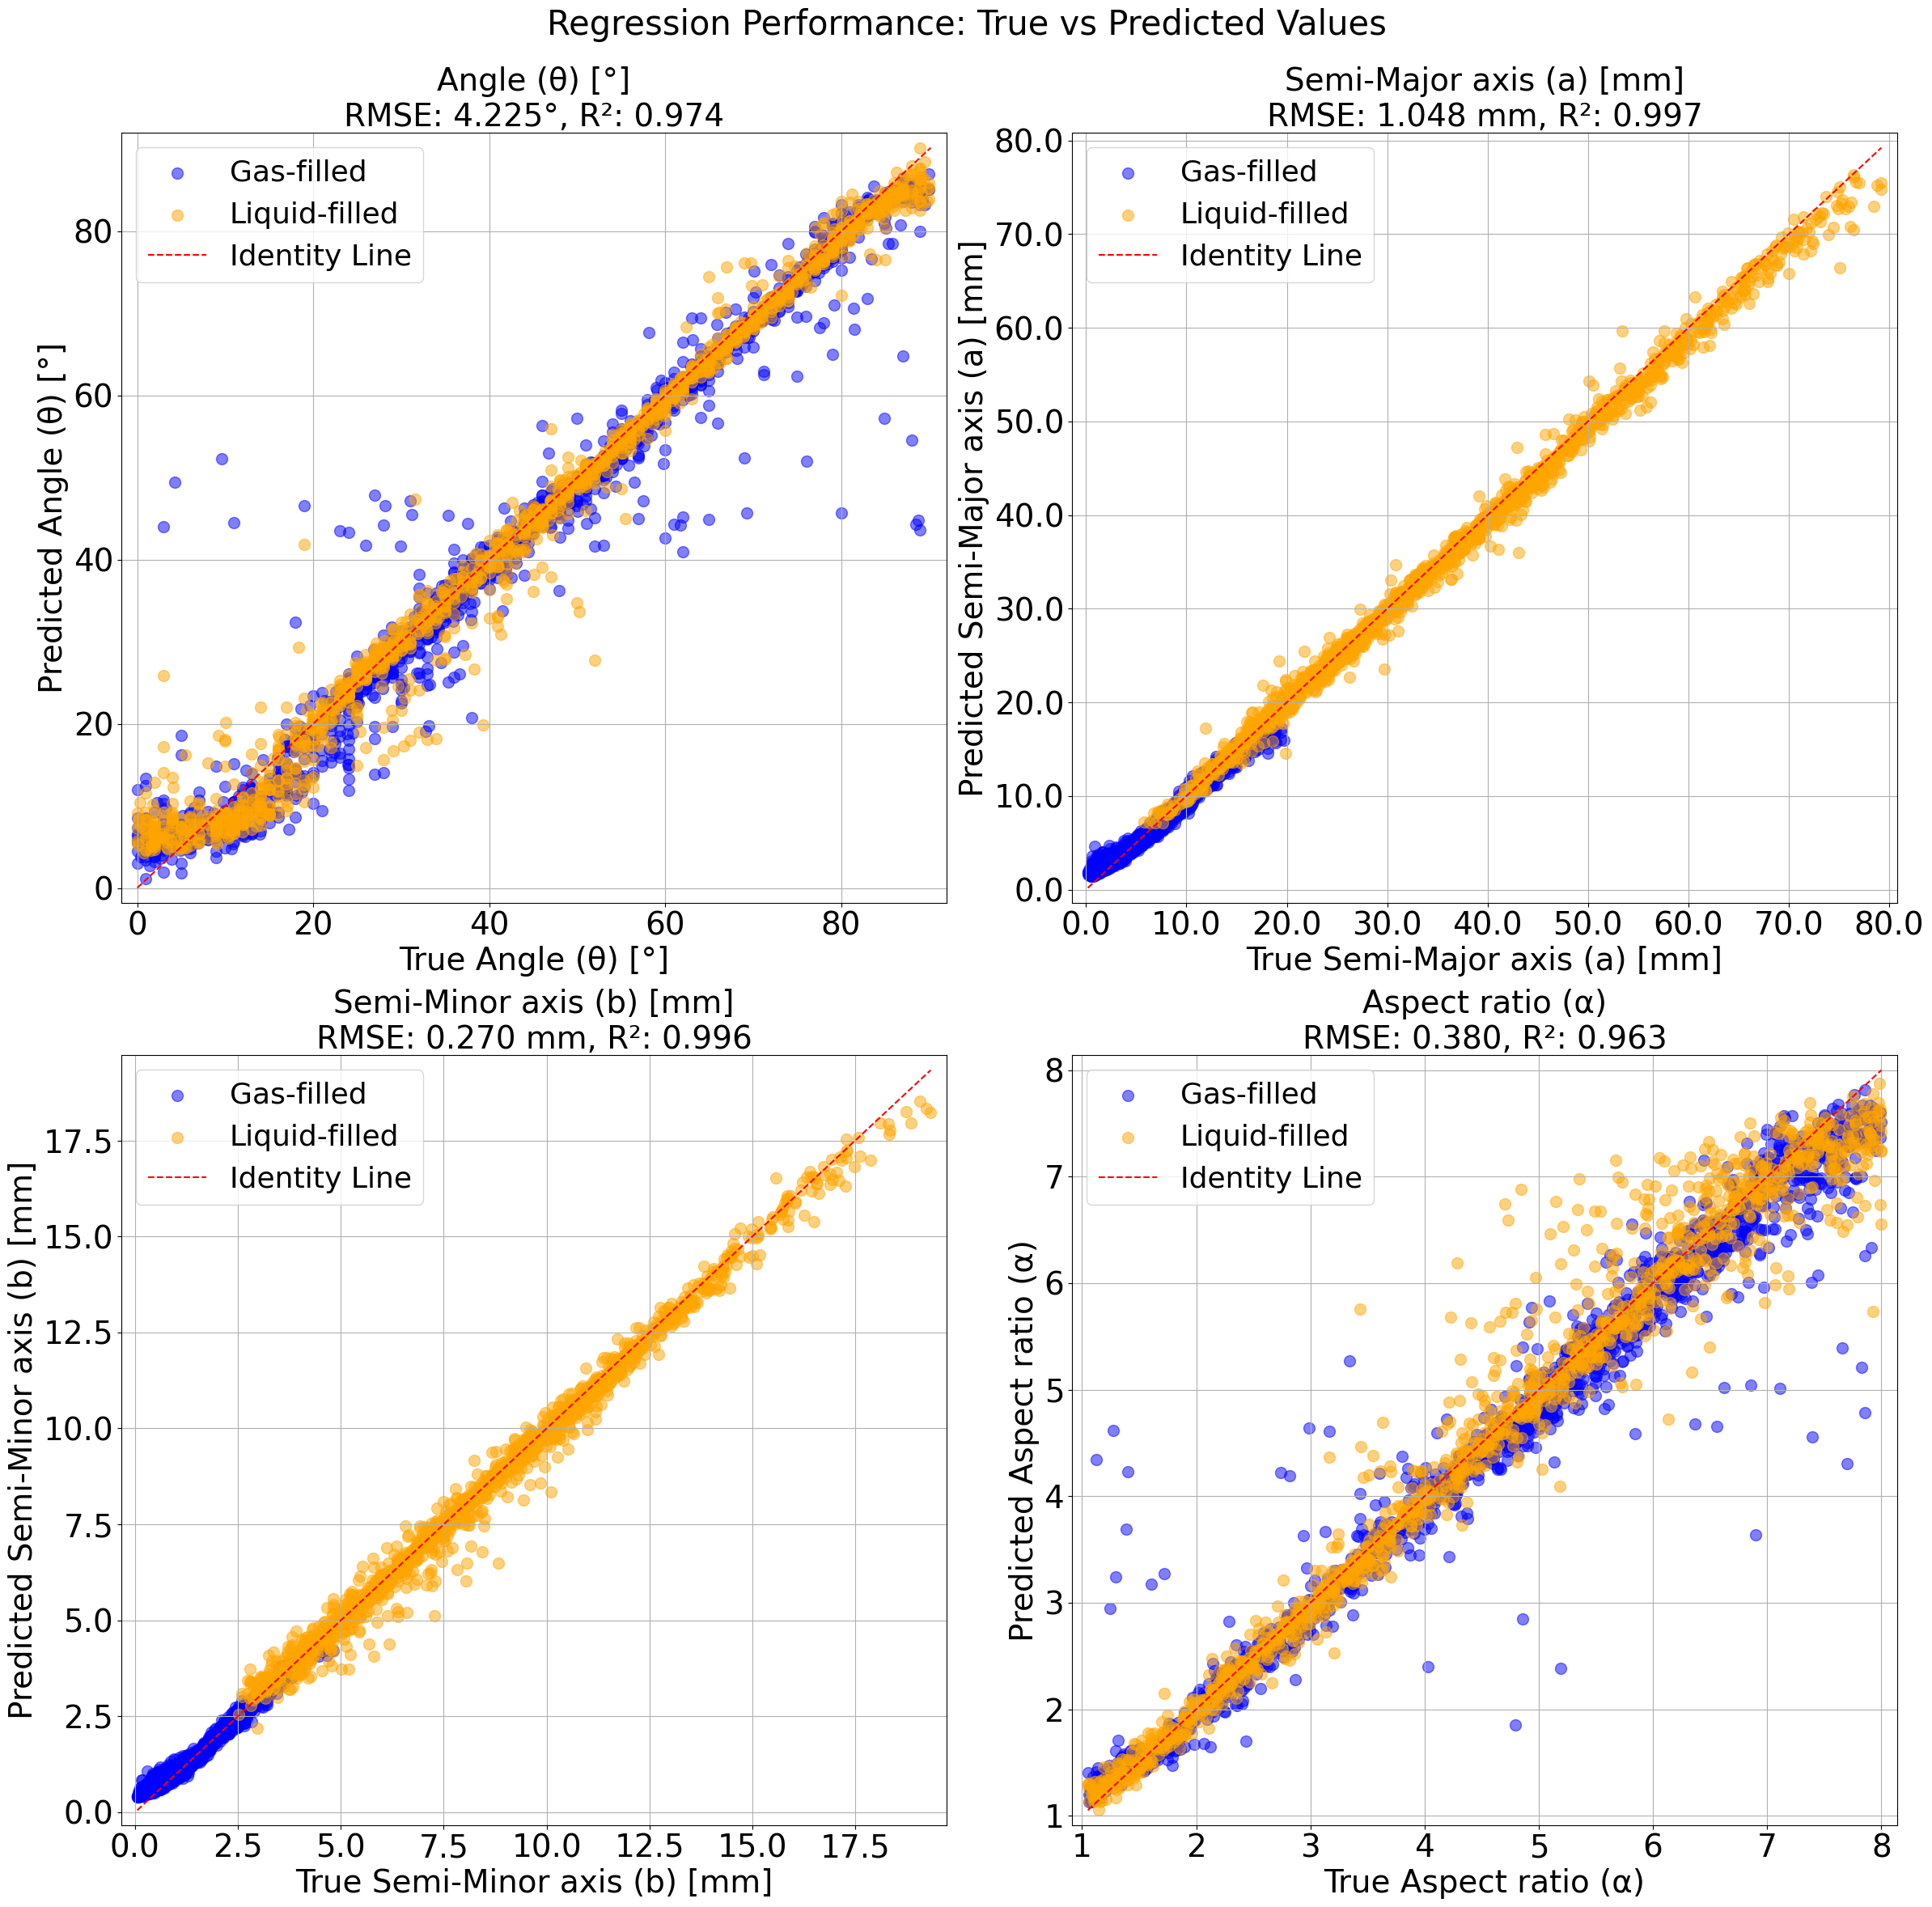


Angle Prediction Error Statistics:
Mean Absolute Error: 2.35 degrees
Median Absolute Error: 1.35 degrees
90th Percentile Error: 5.28 degrees
95th Percentile Error: 7.35 degrees


In [121]:
def evaluate_predictions(model, data_loader, device, label_encoder, reg_train_mean, reg_train_std):
    model.eval()
    all_class_preds = []
    all_class_true = []
    all_reg_preds = []
    all_reg_true = []
    
    with torch.no_grad():
        for inputs, (class_targets, reg_targets) in data_loader:
            inputs = inputs.to(device)
            class_outputs, reg_outputs = model(inputs)
            
            _, predicted_class = torch.max(class_outputs.data, 1)
            
            all_class_preds.extend(predicted_class.cpu().numpy())
            all_class_true.extend(class_targets.numpy())
            all_reg_preds.extend(reg_outputs.cpu().numpy())
            all_reg_true.extend(reg_targets.numpy())
    
    # Convert lists to arrays
    all_class_preds = np.array(all_class_preds)
    all_class_true = np.array(all_class_true)
    all_reg_preds = np.array(all_reg_preds)
    all_reg_true = np.array(all_reg_true)
    


    # Assume reg_train_mean and reg_train_std were computed over four columns
    reg_train_mean = reg_train_mean[:3]
    reg_train_std = reg_train_std[:3]

    all_reg_preds = all_reg_preds * reg_train_std + reg_train_mean
    all_reg_true = all_reg_true[:, :3] * reg_train_std + reg_train_mean


    # Denormalize regression values
    # all_reg_preds = all_reg_preds * reg_train_std + reg_train_mean
    # all_reg_true = all_reg_true * reg_train_std + reg_train_mean

    # Classification metrics
    print("\nClassification Results:")
    correct_predictions = np.sum(all_class_preds == all_class_true)
    total_predictions = len(all_class_true)
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("-" * 50)
    class_names = label_encoder.classes_
    true_labels = label_encoder.inverse_transform(all_class_true)
    pred_labels = label_encoder.inverse_transform(all_class_preds)
    
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels))
    
    # # Confusion Matrix
    # plt.figure(figsize=(12, 8))
    # cm = confusion_matrix(true_labels, pred_labels)
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    #             xticklabels=class_names,
    #             yticklabels=class_names)
    # plt.title('Confusion Matrix')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.tight_layout()
    # plt.show()
    



    # Regression metrics
    print("\nRegression Results:")
    print("-" * 50)
    reg_names = ['theta_i_deg', 'a', 'b', 'alpha']
    
    # Create a figure with 4 subplots for regression metrics
    fig, axes = plt.subplots(2, 2, figsize=(24, 24))
    axes = axes.flatten()  # Flatten to make indexing easier
    # fig.suptitle('Regression Performance: True vs Predicted Values', fontsize=30)


    air_indices = np.array(['air' in label.lower() for label in true_labels])
    liquid_indices = ~air_indices    
    
    # Calculate alpha (derived from a/b)
    all_alpha_true = all_reg_true[:, 1] / all_reg_true[:, 2]  # a/b
    all_alpha_pred = all_reg_preds[:, 1] / all_reg_preds[:, 2]  # a/b
    
    # Create a combined array for plotting the first 3 parameters
    all_combined_true = np.hstack([all_reg_true, all_alpha_true.reshape(-1, 1)])
    all_combined_pred = np.hstack([all_reg_preds, all_alpha_pred.reshape(-1, 1)])
    


    
    
    comp_score = accuracy

    for i, (ax, reg_name) in enumerate(zip(axes, reg_names)):
        if i < 3:  # For the first three parameters (directly predicted)
            true_values = all_reg_true[:, i]
            pred_values = all_reg_preds[:, i]
        else:  # For alpha (calculated as a/b)
            true_values = all_alpha_true
            pred_values = all_alpha_pred
        
        mse = mean_squared_error(true_values, pred_values)
        rmse = np.sqrt(mse)
        r2 = r2_score(true_values, pred_values)
        

        if reg_name != 'alpha':
            comp_score += r2

        if reg_name == 'theta_i_deg':
            reg_name = 'Angle (θ) [°]'
        if reg_name == 'alpha':
            reg_name = 'Aspect ratio (α)'
        if reg_name == 'a':
            reg_name = 'Semi-Major axis (a) [mm]'
        if reg_name == 'b':
            reg_name = 'Semi-Minor axis (b) [mm]'

        print(f"\nMetrics for {reg_name}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        

        
        # Air-filled targets (blue)
        if np.any(air_indices):
            ax.scatter(
                true_values[air_indices], 
                pred_values[air_indices], 
                alpha=0.5, 
                color='blue', 
                label='Gas-filled',
                s=100 
            )
        
        # Liquid-filled targets (orange)
        if np.any(liquid_indices):
            ax.scatter(
                true_values[liquid_indices], 
                pred_values[liquid_indices], 
                alpha=0.5, 
                color='orange', 
                label='Liquid-filled',
                s=100 
            )
        
        # Add identity line
        min_val = min(true_values.min(), pred_values.min())
        max_val = max(true_values.max(), pred_values.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Identity Line')
        

        buffer = (max_val - min_val) * 0.02  # 2% buffer
        min_plot = min_val - buffer
        max_plot = max_val + buffer
        ax.set_xlim(min_plot, max_plot)
        ax.set_ylim(min_plot, max_plot)

        # Format tick labels for a and b to show in millimeters
        if i == 1 or i == 2:  # For a and b parameters (indices 1 and 2)
            # Get current tick locations
            x_ticks = ax.get_xticks()
            y_ticks = ax.get_yticks()
            
            # Filter out ticks that are outside our data range
            x_ticks = x_ticks[(x_ticks >= min_plot) & (x_ticks <= max_plot)]
            y_ticks = y_ticks[(y_ticks >= min_plot) & (y_ticks <= max_plot)]
            
            # Create new tick labels in mm (multiply by 1000)
            x_tick_labels = [f'{x*1000:.1f}' for x in x_ticks]
            y_tick_labels = [f'{y*1000:.1f}' for y in y_ticks]
            
            # Set the new tick labels
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_tick_labels, fontsize=28)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_tick_labels, fontsize=28)

        if i == 0 :
            ax.set_title(f'{reg_name}\nRMSE: {rmse:.3f}°, R²: {r2:.3f}', fontsize=28)
        elif i == 1 or i == 2:
            ax.set_title(f'{reg_name}\nRMSE: {rmse*1000:.3f} mm, R²: {r2:.3f}', fontsize=28)
        else:
            ax.set_title(f'{reg_name}\nRMSE: {rmse:.3f}, R²: {r2:.3f}', fontsize=28)


        # Add labels and title
        ax.set_xlabel(f'True {reg_name}', fontsize=28)
        ax.set_ylabel(f'Predicted {reg_name}',fontsize=28)
        #ax.set_title(f'{reg_name}\nRMSE: {rmse:.6f}, R²: {r2:.3f}', fontsize=28)
        ax.tick_params(axis='both', which='major', labelsize=28)  # Increased tick label size

        ax.legend(fontsize=26)
        ax.grid(True)
    

    
    print()
    print("Model score on classification, angle, a and b:")
    comp_score = comp_score / 4.0
    print(f"Composite score: {comp_score:.3f}")


    fig.suptitle(f'Regression Performance: True vs Predicted Values', fontsize=30)
    

    # fig.text(0.5, -0.01, f'Composite score: {comp_score:.3f}',
    #         ha='center', fontsize=30,)
    
    #plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leaves room for suptitle
    
    
    plt.savefig('../Figures/regression_results_experiment1_low.png', dpi=100, bbox_inches='tight')
    plt.savefig('../Figures/regression_results_experiment1.png', dpi=600, bbox_inches='tight')

    plt.show()

    # Analysis for angle predictions
    angle_errors = np.abs(all_reg_preds[:, 0] - all_reg_true[:, 0])

    # Print angle error statistics
    print("\nAngle Prediction Error Statistics:")
    print(f"Mean Absolute Error: {np.mean(angle_errors):.2f} degrees")
    print(f"Median Absolute Error: {np.median(angle_errors):.2f} degrees")
    print(f"90th Percentile Error: {np.percentile(angle_errors, 90):.2f} degrees")
    print(f"95th Percentile Error: {np.percentile(angle_errors, 95):.2f} degrees")
    
    # Create a complete metrics dictionary including alpha
    alpha_rmse = np.sqrt(mean_squared_error(all_alpha_true, all_alpha_pred))
    alpha_r2 = r2_score(all_alpha_true, all_alpha_pred)
    
    return {
        'classification': {
            'true': true_labels,
            'pred': pred_labels,
        },
        'regression': {
            'true': all_reg_true,
            'pred': all_reg_preds,
            'alpha_true': all_alpha_true,
            'alpha_pred': all_alpha_pred,
            'metrics': {
                'rmse': [np.sqrt(mean_squared_error(all_reg_true[:, i], all_reg_preds[:, i])) for i in range(3)] + [alpha_rmse],
                'r2': [r2_score(all_reg_true[:, i], all_reg_preds[:, i]) for i in range(3)] + [alpha_r2]
            }
        }
    }

model.load_state_dict(torch.load(model_path))
metrics = evaluate_predictions(model, test_loader, device, label_encoder, reg_train_mean, reg_train_std)

Outlier analysis on angle predictions


===== OUTLIER ANALYSIS =====
Found 37 outliers with angle error > 15.0° (1.23% of samples)

Outlier distribution by true class:
airfilled: 29 outliers (78.38%)
liquid: 8 outliers (21.62%)

Misclassification analysis:
Number of outliers that are also misclassified: 0 (0.00%)


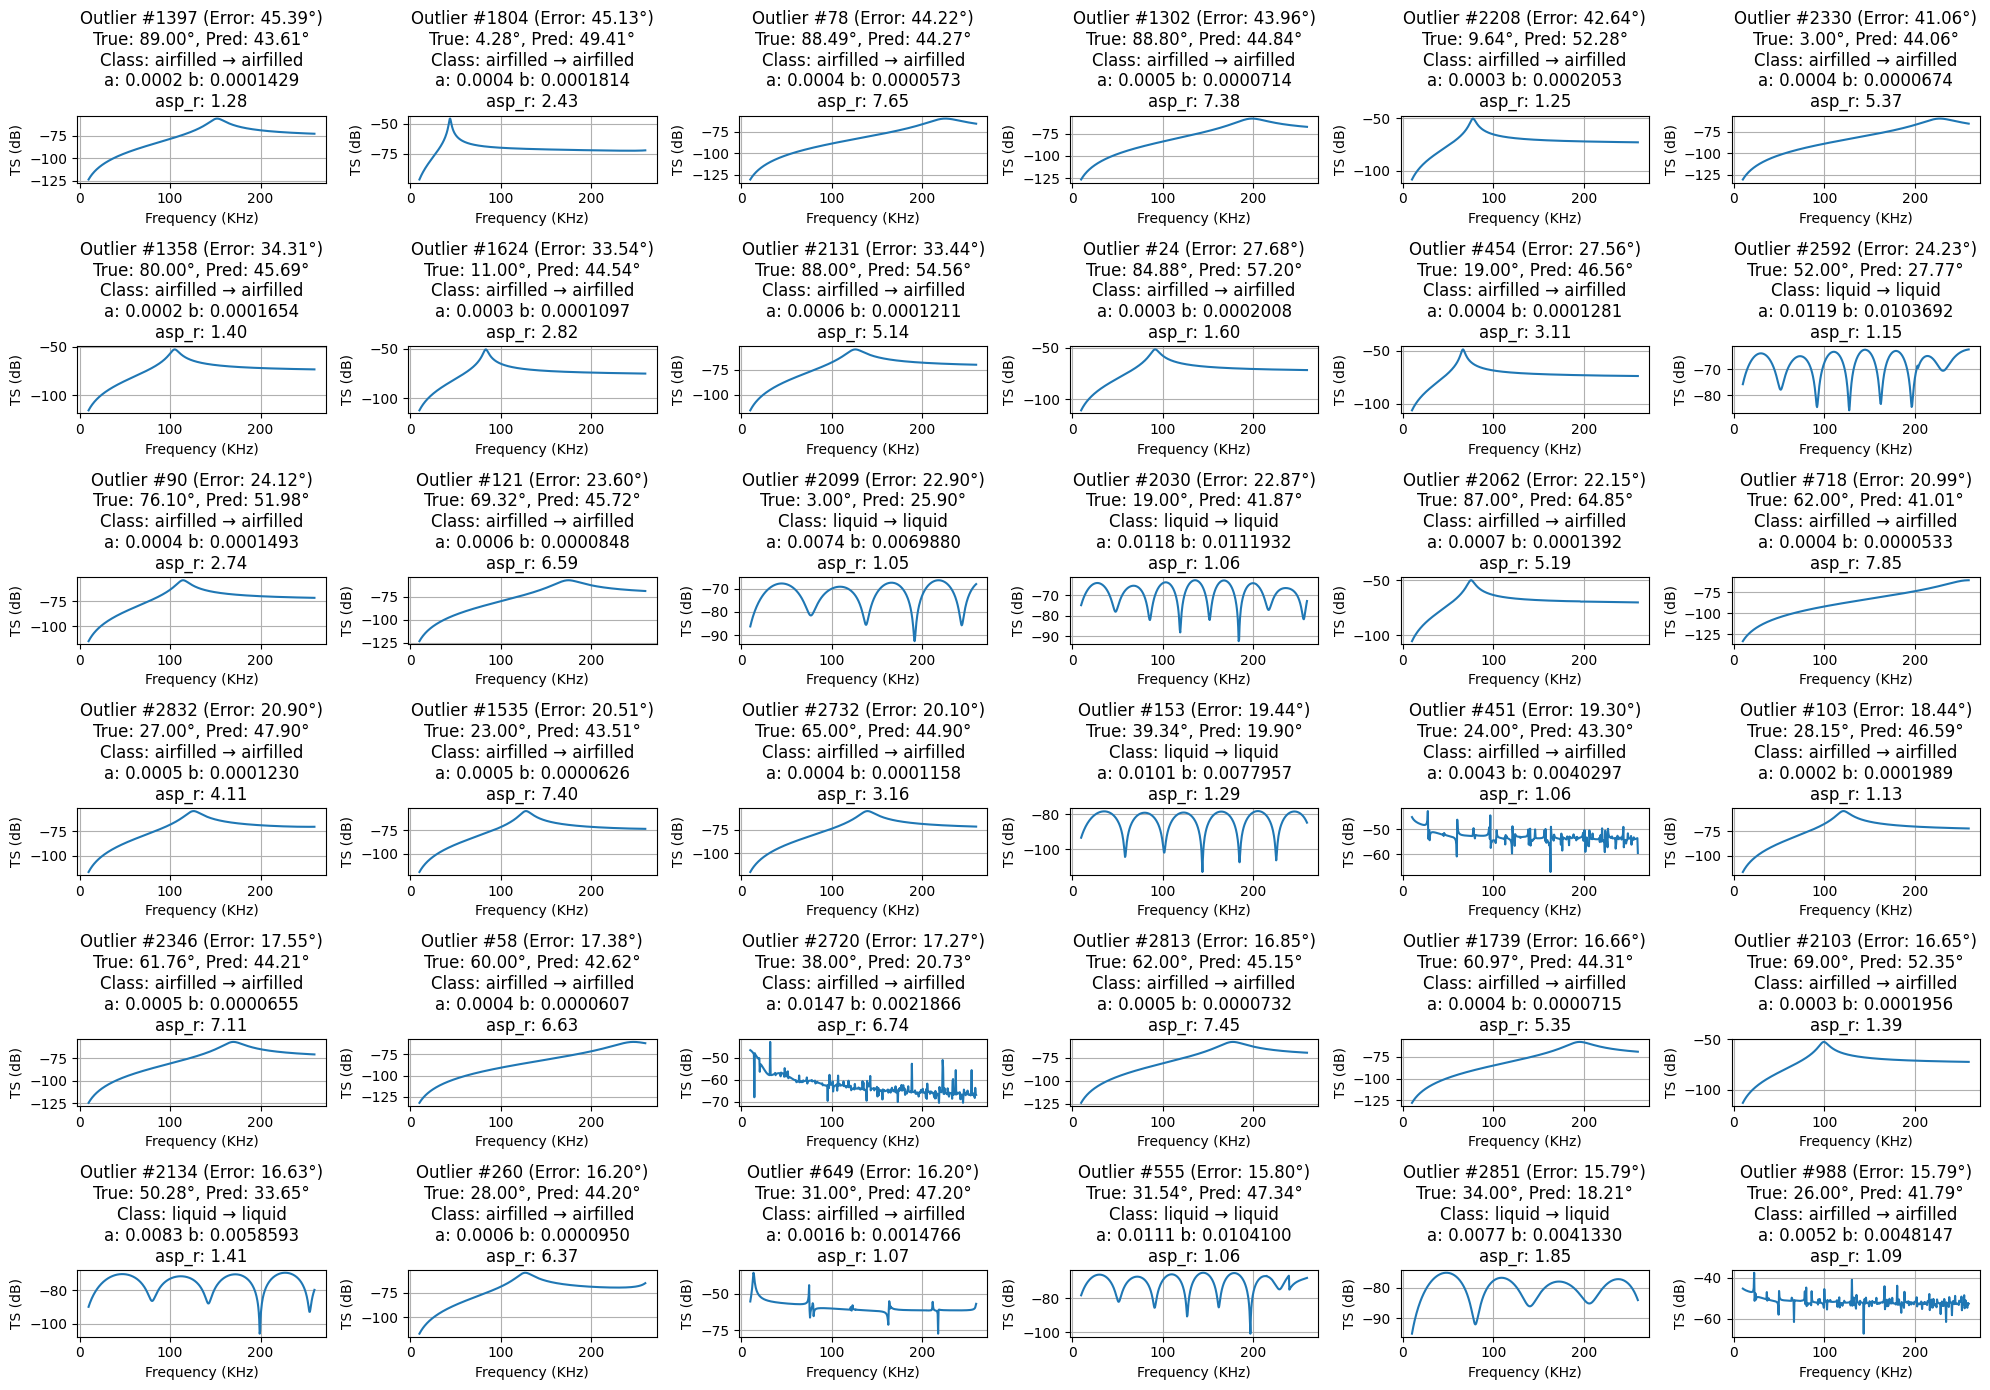

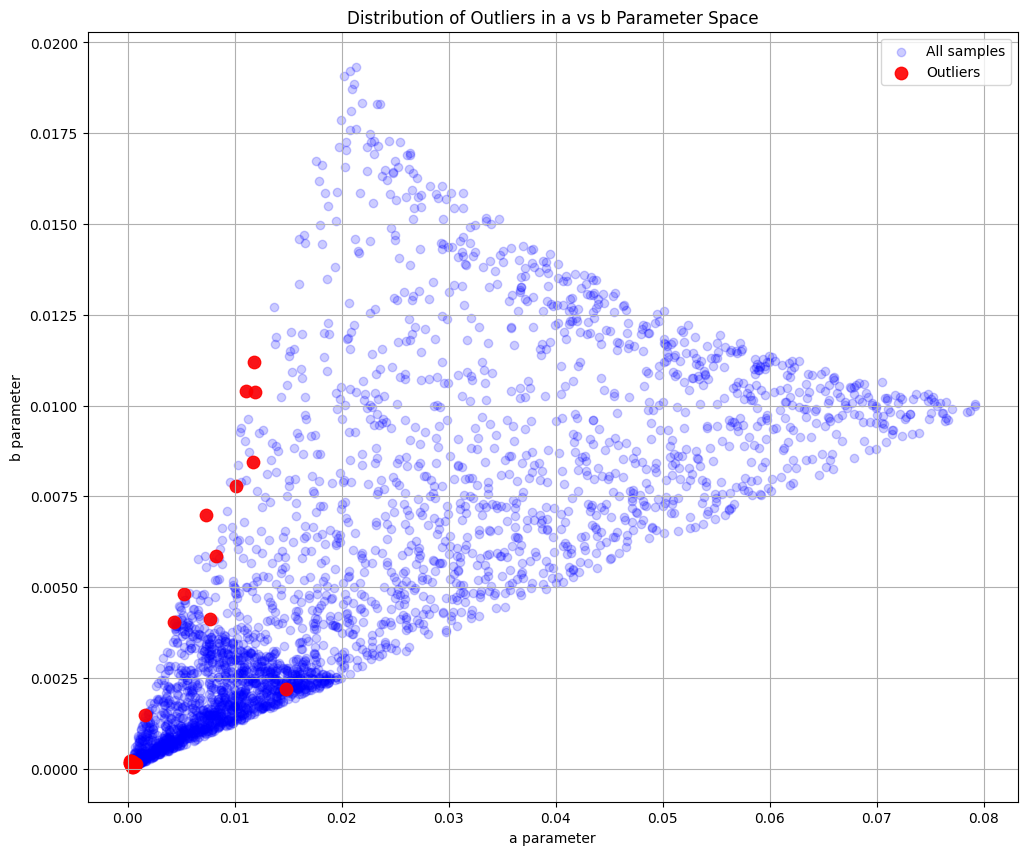

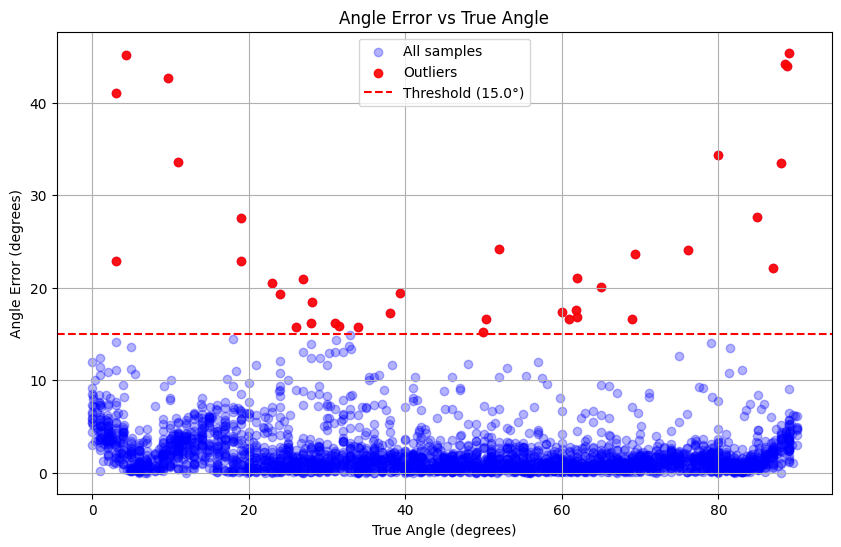

AIR
d: 1.2759258
d: 2.4342139
d: 7.6544729
d: 7.3844225
d: 1.2472153
d: 5.3725422
d: 1.4005345
d: 2.8205238
d: 5.1410458
d: 1.6036679
d: 3.1072055
d: 2.7418080
d: 6.5853074
d: 5.1903328
d: 7.8545092
d: 4.1087125
d: 7.3980411
d: 3.1641288
d: 1.0633001
d: 1.1265532
d: 7.1136190
d: 6.6254440
d: 6.7433242
d: 7.4470230
d: 5.3534253
d: 1.3853842
d: 6.3681450
d: 1.0693175
d: 1.0900199

LIQ
d: 1.1491341
d: 1.0519600
d: 1.0558890
d: 1.2948980
d: 1.4091800
d: 1.0617570
d: 1.8547199


Top 10 worst outliers:
Index | True Class | Pred Class | True Angle | Pred Angle | Error
----------------------------------------------------------------------
 1397 | airfilled  | airfilled  |      89.00 |      43.61 | 45.39
 1804 | airfilled  | airfilled  |       4.28 |      49.41 | 45.13
   78 | airfilled  | airfilled  |      88.49 |      44.27 | 44.22
 1302 | airfilled  | airfilled  |      88.80 |      44.84 | 43.96
 2208 | airfilled  | airfilled  |       9.64 |      52.28 | 42.64
 2330 | airfilled  | airfilled 

In [38]:
def evaluate_predictions_with_outlier_analysis(model, data_loader, device, label_encoder, reg_train_mean, reg_train_std, X_train_mean, X_train_std, angle_error_threshold=10.0):
    model.eval()
    all_class_preds = []
    all_class_true = []
    all_reg_preds = []
    all_reg_true = []
    # Store the original input signals for later time domain analysis
    all_input_signals = []
    all_indices = []  # Store indices for reference
    
    idx = 0
    with torch.no_grad():
        for inputs, (class_targets, reg_targets) in data_loader:
            batch_size = inputs.size(0)
            inputs = inputs.to(device)
            class_outputs, reg_outputs = model(inputs)
            
            _, predicted_class = torch.max(class_outputs.data, 1)
            
            all_class_preds.extend(predicted_class.cpu().numpy())
            all_class_true.extend(class_targets.numpy())
            all_reg_preds.extend(reg_outputs.cpu().numpy())
            all_reg_true.extend(reg_targets.numpy())
            all_input_signals.extend(inputs.cpu().numpy())
            all_indices.extend(range(idx, idx + batch_size))
            idx += batch_size
    
    # Convert lists to arrays
    all_class_preds = np.array(all_class_preds)
    all_class_true = np.array(all_class_true)
    all_reg_preds = np.array(all_reg_preds)
    all_reg_true = np.array(all_reg_true)
    all_input_signals = np.array(all_input_signals)
    all_indices = np.array(all_indices)
    
    
    # Assume reg_train_mean and reg_train_std were computed over four columns
    reg_train_mean = reg_train_mean[:3]
    reg_train_std = reg_train_std[:3]

    all_reg_preds = all_reg_preds * reg_train_std + reg_train_mean
    all_reg_true = all_reg_true[:, :3] * reg_train_std + reg_train_mean

    
    # Denormalize regression values
    # all_reg_preds = all_reg_preds * reg_train_std + reg_train_mean
    # all_reg_true = all_reg_true * reg_train_std + reg_train_mean
    

    # Denormalize input signals - this is important for proper time domain visualization
    all_input_signals = all_input_signals * X_train_std + X_train_mean

    # Classification metrics
    class_names = label_encoder.classes_
    true_labels = label_encoder.inverse_transform(all_class_true)
    pred_labels = label_encoder.inverse_transform(all_class_preds)
    
    # ===== OUTLIER ANALYSIS =====
    # Calculate angle errors
    angle_errors = np.abs(all_reg_preds[:, 0] - all_reg_true[:, 0])
    
    # Create mask for outliers (angle error > threshold)
    outlier_mask = angle_errors > angle_error_threshold
    outlier_indices = np.where(outlier_mask)[0]
    n_outliers = len(outlier_indices)
    
    print(f"\n===== OUTLIER ANALYSIS =====")
    print(f"Found {n_outliers} outliers with angle error > {angle_error_threshold}° ({n_outliers/len(angle_errors)*100:.2f}% of samples)")
    
    if n_outliers > 0:
        # Get data for outliers
        outlier_true_labels = true_labels[outlier_indices]
        outlier_pred_labels = pred_labels[outlier_indices]
        outlier_true_angles = all_reg_true[outlier_indices, 0]
        outlier_pred_angles = all_reg_preds[outlier_indices, 0]
        outlier_angle_errors = angle_errors[outlier_indices]
        outlier_signals = all_input_signals[outlier_indices]
        outlier_original_indices = all_indices[outlier_indices]

        outlier_true_a = all_reg_true[outlier_indices, 1]
        outlier_pred_a = all_reg_preds[outlier_indices, 1]

        outlier_true_b = all_reg_true[outlier_indices, 2]
        outlier_pred_b = all_reg_preds[outlier_indices, 2]
        
        # Analyze outlier distribution by class
        class_distribution = {}
        for cls in class_names:
            count = np.sum(outlier_true_labels == cls)
            class_distribution[cls] = count
        
        print("\nOutlier distribution by true class:")
        for cls, count in class_distribution.items():
            print(f"{cls}: {count} outliers ({count/n_outliers*100:.2f}%)")
        
        # Analyze if the outliers are misclassified
        misclassified = outlier_true_labels != outlier_pred_labels
        print(f"\nMisclassification analysis:")
        print(f"Number of outliers that are also misclassified: {np.sum(misclassified)} ({np.sum(misclassified)/n_outliers*100:.2f}%)")
        
        # Sort outliers by error magnitude (descending)
        sorted_idx = np.argsort(outlier_angle_errors)[::-1]
        
        # Extract data for the top outliers
        max_outliers_to_visualize = min(36, n_outliers)
        top_outliers_idx = sorted_idx[:max_outliers_to_visualize]
        
        # === TIME DOMAIN VISUALIZATION ===
        # Plot time domain signals for the worst outliers
        fig, axs = plt.subplots(6, 6, figsize=(20, 14))
        axs = axs.flatten()
        air = ""
        liq = ""
        for i in range(max_outliers_to_visualize):
            idx = top_outliers_idx[i]
            original_idx = outlier_original_indices[idx]
            signal = outlier_signals[idx].squeeze()  # Remove channel dimension
            



            ax = axs[i]
            # Plot the time domain signal
            ax.plot(np.arange(10.0, 10.0 + 0.5 * len(signal), 0.5),signal)
            true_angle = outlier_true_angles[idx]
            pred_angle = outlier_pred_angles[idx]
            true_class = outlier_true_labels[idx]
            pred_class = outlier_pred_labels[idx]

            true_a = outlier_true_a[idx]
            pred_a = outlier_pred_a[idx]
            
            true_b = outlier_true_b[idx]
            pred_b = outlier_pred_b[idx]


            

            if true_class == "airfilled":
                air +=(f"d: {(true_a/true_b):.7f}\n")
            else:
                liq +=(f"d: {(true_a/true_b):.7f}\n")




            ax.set_title(f"Outlier #{original_idx} (Error: {outlier_angle_errors[idx]:.2f}°)\n"
                         f"True: {true_angle:.2f}°, Pred: {pred_angle:.2f}°\n"
                         f"Class: {true_class} → {pred_class}\n"
                        f"a: {true_a:.4f} b: {true_b:.7f}\n"
                        f"asp_r: {(true_a/true_b):.2f}")
                        
            ax.set_xlabel('Frequency (KHz)')
            ax.set_ylabel('TS (dB)')
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # === 2D PARAMETER VISUALIZATION (a vs b) ===
        plt.figure(figsize=(12, 10))
        
        # Plot all points with lower opacity
        plt.scatter(
            all_reg_true[:, 1],  # a parameter
            all_reg_true[:, 2],  # b parameter
            c='blue',
            alpha=0.2,
            label='All samples'
        )

        
        # Plot outliers with higher opacity and color based on error magnitude
        scatter = plt.scatter(
            all_reg_true[outlier_indices, 1],  # a parameter for outliers
            all_reg_true[outlier_indices, 2],  # b parameter for outliers
            # c=outlier_angle_errors,            # color by error magnitude
            # cmap='Reds',
            c='Red',
            s=80,                              # larger point size
            alpha=0.9,
            label='Outliers'
        )
         
        plt.xlabel('a parameter')
        plt.ylabel('b parameter')
        plt.title('Distribution of Outliers in a vs b Parameter Space')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Create a 2D scatter plot of angle vs angle error
        plt.figure(figsize=(10, 6))
        plt.scatter(all_reg_true[:, 0], angle_errors, alpha=0.3, c='blue', label='All samples')
        plt.scatter(outlier_true_angles, outlier_angle_errors, alpha=0.9, c='red', label='Outliers')
        plt.axhline(y=angle_error_threshold, color='r', linestyle='--', label=f'Threshold ({angle_error_threshold}°)')
        plt.xlabel('True Angle (degrees)')
        plt.ylabel('Angle Error (degrees)')
        plt.title('Angle Error vs True Angle')
        plt.legend()
        plt.grid(True)
        plt.show()
        

        print("AIR")
        print(air)
        print("LIQ")
        print(liq)
        # Table of top 10 worst outliers
        if n_outliers >= 16:
            top10_indices = sorted_idx[:16]
            
            print("\nTop 10 worst outliers:")
            print("Index | True Class | Pred Class | True Angle | Pred Angle | Error")
            print("-" * 70)
            
            for i, idx in enumerate(top10_indices):
                orig_idx = outlier_original_indices[idx]
                print(f"{orig_idx:5d} | {outlier_true_labels[idx]:10s} | {outlier_pred_labels[idx]:10s} | "
                      f"{outlier_true_angles[idx]:10.2f} | {outlier_pred_angles[idx]:10.2f} | {outlier_angle_errors[idx]:5.2f}")
    


    
    return {
        'classification': {
            'true': true_labels,
            'pred': pred_labels,
        },
        'regression': {
            'true': all_reg_true,
            'pred': all_reg_preds,
        },
        'outliers': {
            'indices': outlier_original_indices if n_outliers > 0 else [],
            'true_labels': outlier_true_labels if n_outliers > 0 else [],
            'pred_labels': outlier_pred_labels if n_outliers > 0 else [],
            'true_angles': outlier_true_angles if n_outliers > 0 else [],
            'pred_angles': outlier_pred_angles if n_outliers > 0 else [],
            'errors': outlier_angle_errors if n_outliers > 0 else []
        }
    }


metrics = evaluate_predictions_with_outlier_analysis( 
    model, 
    test_loader, 
    device, 
    label_encoder, 
    reg_train_mean, 
    reg_train_std,
    X_train_mean,
    X_train_std,
    angle_error_threshold=15.0
)


===== THETA PARAMETER OUTLIER VISUALIZATION BY CLASS =====
Found 37 outliers with angle error > 15.00° (1.23% of samples)
airfilled: 29 outliers (78.38%)
liquid: 8 outliers (21.62%)


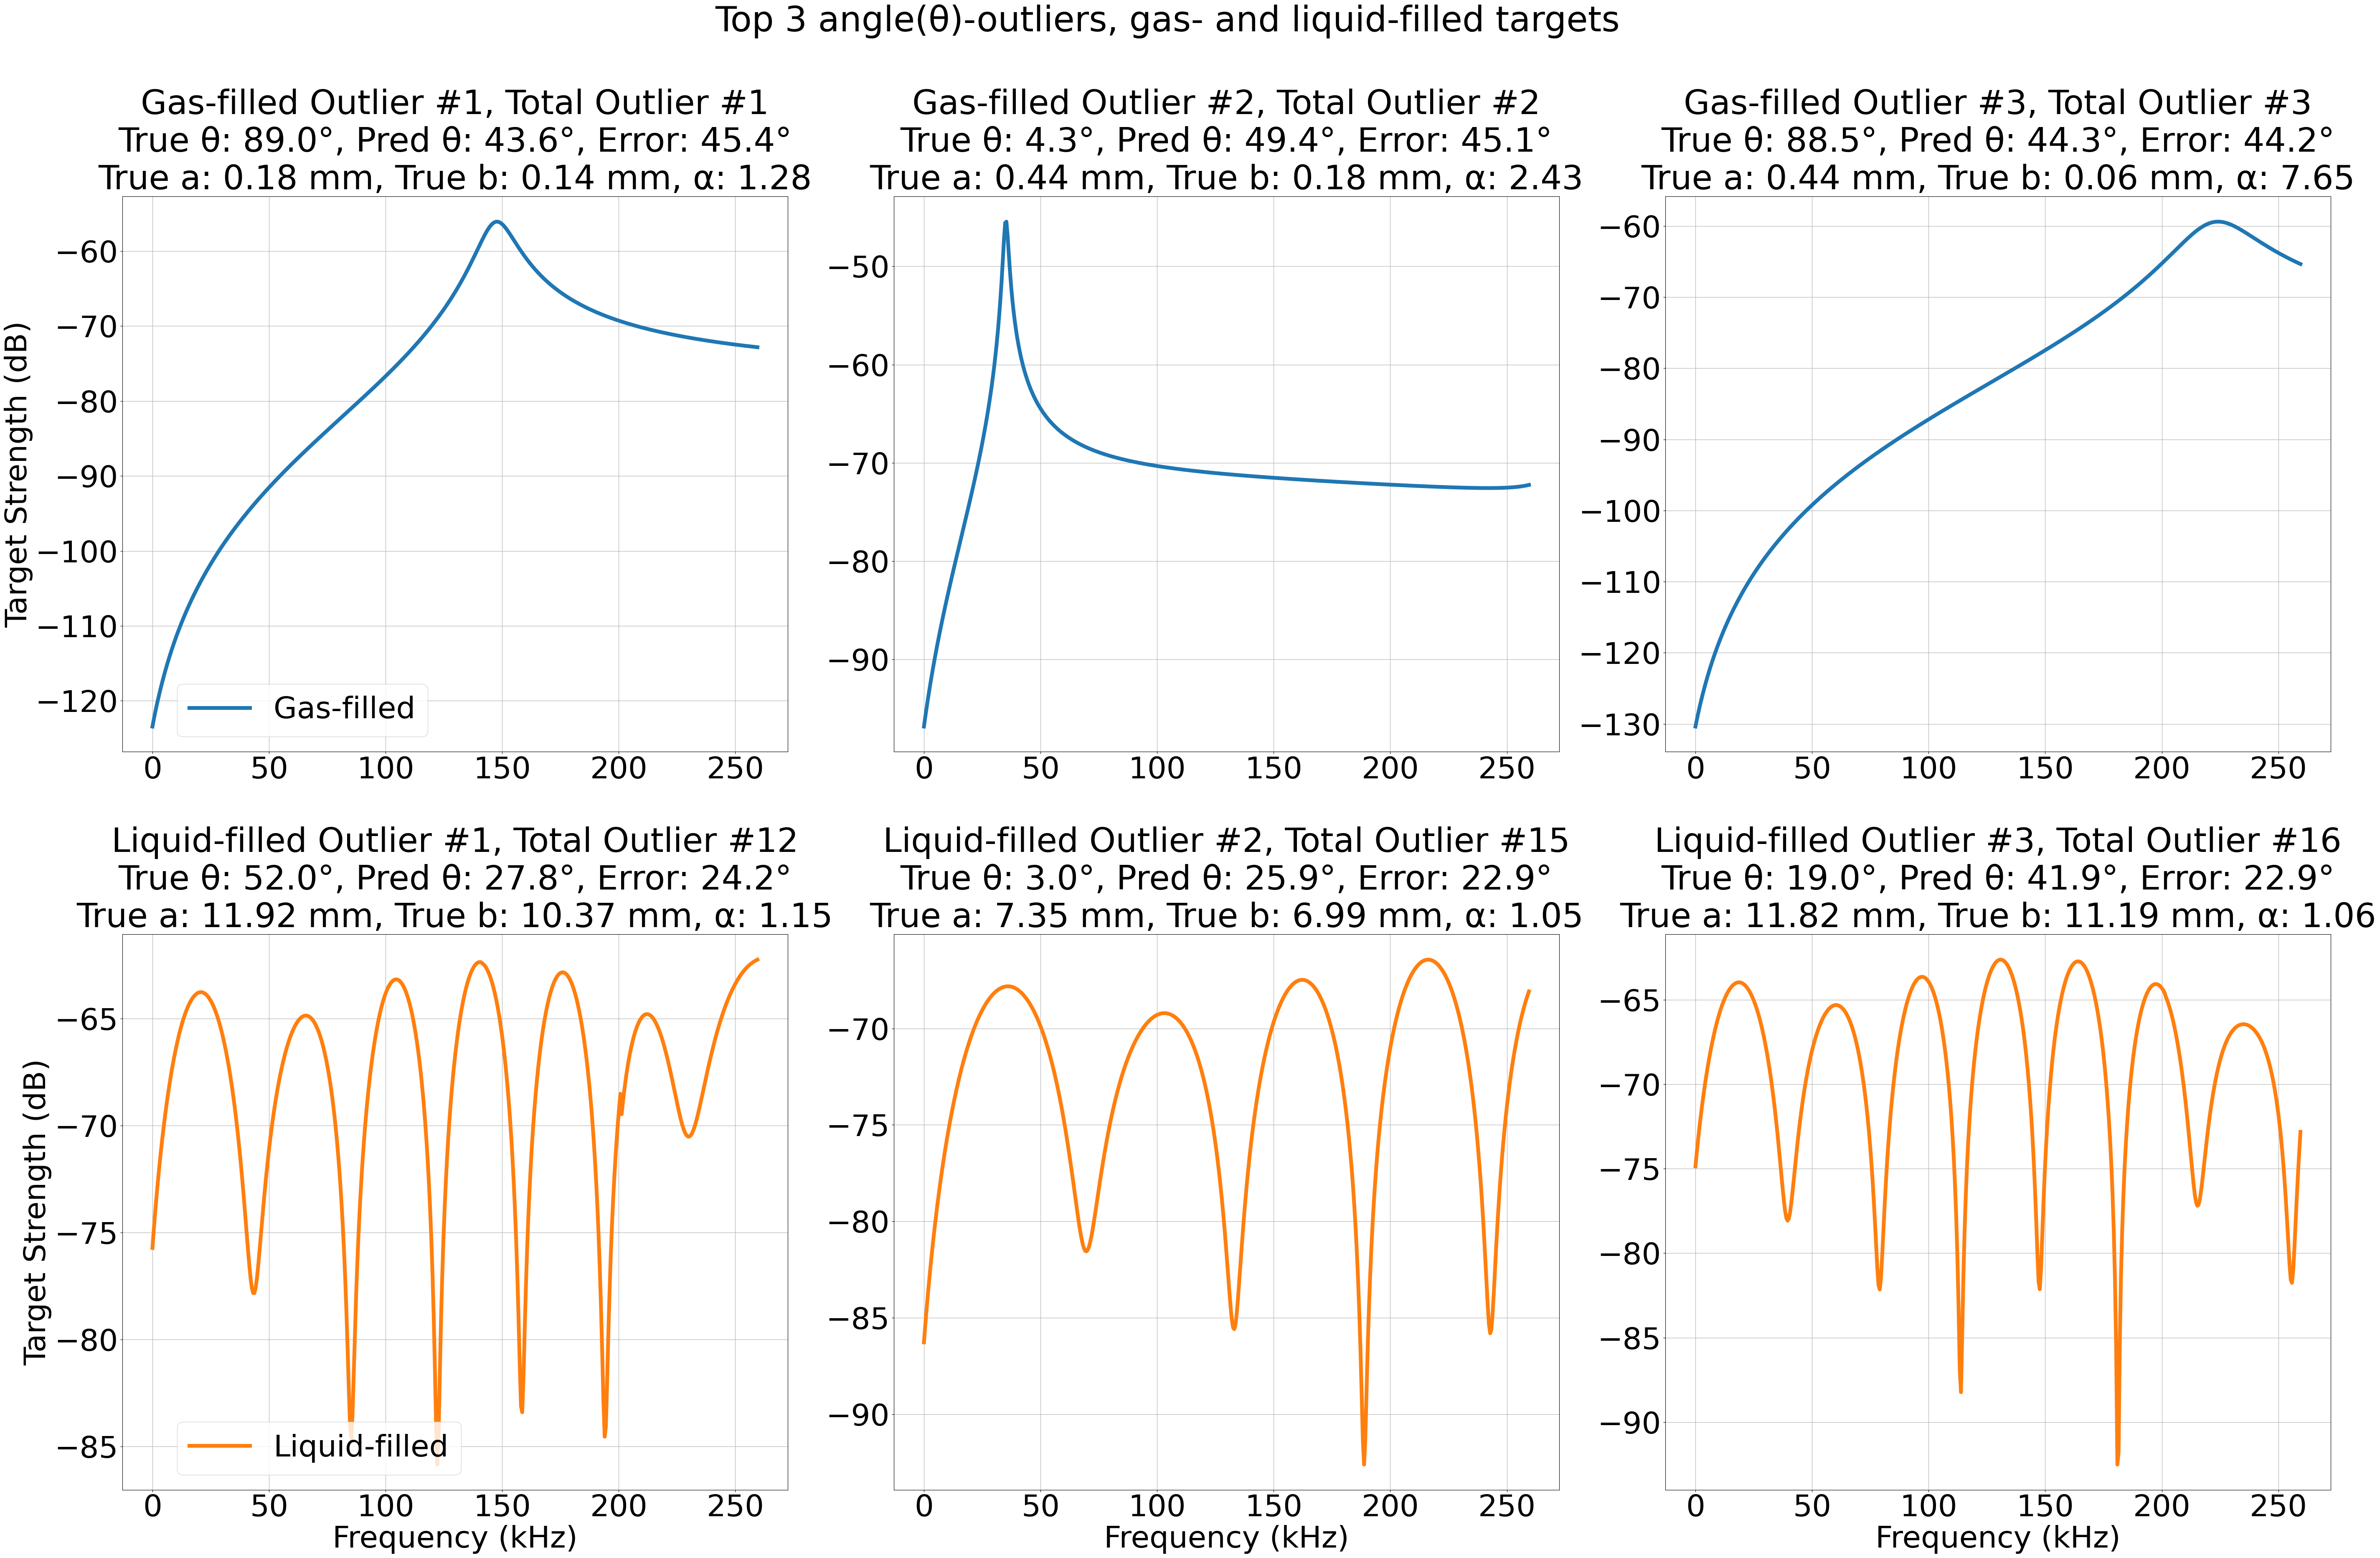

In [ ]:
def visualize_top_theta_outliers_by_class(model, data_loader, device, label_encoder, reg_train_mean, reg_train_std, 
                               X_train_mean, X_train_std, theta_error_threshold=15.0, top_n=3):
    """
    Visualize the top N outliers for each class based on theta (angle) error magnitude.
    
    Args:
        model: Trained model
        data_loader: Data loader for test set
        device: Device to run evaluation on
        label_encoder: Label encoder for classification
        reg_train_mean, reg_train_std: Normalization parameters for regression
        X_train_mean, X_train_std: Normalization parameters for input signals
        theta_error_threshold: Threshold for defining angle outliers (in degrees)
        top_n: Number of top outliers to visualize per class
    """
    model.eval()
    all_class_preds = []
    all_class_true = []
    all_reg_preds = []
    all_reg_true = []
    all_input_signals = []
    all_indices = []
    
    idx = 0
    with torch.no_grad():
        for inputs, (class_targets, reg_targets) in data_loader:
            batch_size = inputs.size(0)
            inputs = inputs.to(device)
            class_outputs, reg_outputs = model(inputs)
            
            _, predicted_class = torch.max(class_outputs.data, 1)
            
            all_class_preds.extend(predicted_class.cpu().numpy())
            all_class_true.extend(class_targets.numpy())
            all_reg_preds.extend(reg_outputs.cpu().numpy())
            all_reg_true.extend(reg_targets.numpy())
            all_input_signals.extend(inputs.cpu().numpy())
            all_indices.extend(range(idx, idx + batch_size))
            idx += batch_size
    
    # Convert lists to arrays
    all_class_preds = np.array(all_class_preds)
    all_class_true = np.array(all_class_true)
    all_reg_preds = np.array(all_reg_preds)
    all_reg_true = np.array(all_reg_true)
    all_input_signals = np.array(all_input_signals)
    all_indices = np.array(all_indices)
    
    # Denormalize regression values
    reg_train_mean_subset = reg_train_mean[:3]
    reg_train_std_subset = reg_train_std[:3]
    
    all_reg_preds = all_reg_preds * reg_train_std_subset + reg_train_mean_subset
    all_reg_true = all_reg_true[:, :3] * reg_train_std_subset + reg_train_mean_subset
    
    # Denormalize input signals
    all_input_signals = all_input_signals * X_train_std + X_train_mean
    
    # Get class labels
    class_names = label_encoder.classes_
    true_labels = label_encoder.inverse_transform(all_class_true)
    pred_labels = label_encoder.inverse_transform(all_class_preds)
    
    # ===== THETA PARAMETER OUTLIER ANALYSIS =====
    # Calculate angle errors (absolute difference)
    theta_errors = np.abs(all_reg_preds[:, 0] - all_reg_true[:, 0])
    
    # Create mask for outliers
    outlier_mask = theta_errors > theta_error_threshold
    outlier_indices = np.where(outlier_mask)[0]
    n_outliers = len(outlier_indices)
    
    print(f"\n===== THETA PARAMETER OUTLIER VISUALIZATION BY CLASS =====")
    print(f"Found {n_outliers} outliers with angle error > {theta_error_threshold:.2f}° ({n_outliers/len(theta_errors)*100:.2f}% of samples)")
    
    if n_outliers > 0:
        # Get data for outliers
        outlier_true_labels = true_labels[outlier_indices]
        outlier_pred_labels = pred_labels[outlier_indices]
        
        outlier_true_theta = all_reg_true[outlier_indices, 0]
        outlier_pred_theta = all_reg_preds[outlier_indices, 0]
        outlier_theta_errors = theta_errors[outlier_indices]
        
        outlier_true_a = all_reg_true[outlier_indices, 1]
        outlier_pred_a = all_reg_preds[outlier_indices, 1]
        outlier_true_b = all_reg_true[outlier_indices, 2]
        outlier_pred_b = all_reg_preds[outlier_indices, 2]
        
        # Calculate aspect ratios for outliers
        outlier_true_alpha = outlier_true_a / outlier_true_b
        outlier_pred_alpha = outlier_pred_a / outlier_pred_b
        
        outlier_signals = all_input_signals[outlier_indices]
        outlier_original_indices = all_indices[outlier_indices]
        
        # Analyze outlier distribution by class
        class_distribution = {}
        for cls in class_names:
            class_mask = outlier_true_labels == cls
            class_indices = np.where(class_mask)[0]
            count = len(class_indices)
            class_distribution[cls] = count
            
            print(f"{cls}: {count} outliers ({count/n_outliers*100:.2f}%)")
        
        # Global sorting for all outliers by theta error
        global_sorted_idx = np.argsort(outlier_theta_errors)[::-1]

        # Separate outliers by class
        class_outlier_indices = {}
        for cls in class_names:
            class_mask = outlier_true_labels == cls
            class_indices = np.where(class_mask)[0]
            
            if len(class_indices) > 0:
                # Sort by theta error magnitude (descending)
                class_sorted_idx = class_indices[np.argsort(outlier_theta_errors[class_indices])[::-1]]
                class_outlier_indices[cls] = class_sorted_idx[:min(top_n, len(class_sorted_idx))]
            else:
                class_outlier_indices[cls] = []
        
        # Create figure with top N outliers for each class
        n_classes = len(class_names)
        fig, axs = plt.subplots(n_classes, top_n, figsize=(56, 19 * n_classes))
        fig.suptitle('Top 3 angle(θ)-outliers, gas- and liquid-filled targets', fontsize=60)
        
        # Handle case with only one class (make sure axs is 2D)
        if n_classes == 1:
            axs = np.array([axs])

        #plt.subplots_adjust(wspace=0.9)    
        
        for i, cls in enumerate(class_names):
            class_top_indices = class_outlier_indices[cls]
            for j in range(top_n):
                ax = axs[i, j]
                
                if j < len(class_top_indices):  # Ensure we don't exceed the available outliers
                    idx = class_top_indices[j]
                    original_idx = outlier_original_indices[idx]
                    signal = outlier_signals[idx].squeeze()
                    
                    # Plot the frequency domain signal with class-specific colors
                    if cls == 'airfilled':
                        ax.plot(np.arange(0, 260, 260/len(signal)),
                                 signal, linewidth=6.5, color='tab:blue', label = 'Gas-filled')
                        name = 'Gas-filled'
                    else:  # liquid
                        ax.plot(np.arange(0, 260, 260/len(signal)),
                                 signal, linewidth=6.5, color='tab:orange', label = "Liquid-filled")
                        name = 'Liquid-filled'
                    
                    # Get values for this outlier
                    true_theta = outlier_true_theta[idx]
                    pred_theta = outlier_pred_theta[idx]
                    true_a = outlier_true_a[idx]
                    true_b = outlier_true_b[idx]
                    true_alpha = outlier_true_alpha[idx]
                    aspect_ratio = true_a / true_b
                    
                    # Get global rank
                    global_rank = np.where(global_sorted_idx == idx)[0][0] + 1  # +1 for 1-based indexing
                    
                    ax.set_title(f"\n{name} Outlier #{j+1}, Total Outlier #{global_rank}\n"
                                f"True θ: {true_theta:.1f}°, Pred θ: {pred_theta:.1f}°, Error: {outlier_theta_errors[idx]:.1f}°\n"
                                f"True a: {true_a*1000:.2f} mm, True b: {true_b*1000:.2f} mm, α: {aspect_ratio:.2f}", fontsize = 58)
                    
                    if j == 0:
                        ax.set_ylabel('Target Strength (dB)', fontsize = 52)
                        ax.legend(loc='lower left', fontsize=52, framealpha = 0.8, bbox_to_anchor=(0.06, 0))

                    if cls == 'liquid':
                        ax.set_xlabel('Frequency (kHz)', fontsize = 52)
                    
                    ax.tick_params(axis='both', which='major', labelsize=52)
                    ax.grid(True)
                else:
                    # If we have fewer than top_n outliers for this class, leave the plot empty
                    ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.98], w_pad=3.3, h_pad=0.7)
        plt.savefig('../Figures/top_theta_outliers_by_class_low.png', dpi=100, bbox_inches='tight')
        #plt.savefig('../Figures/top_theta_outliers_by_class.png', dpi=600, bbox_inches='tight')
        plt.show()
        
        return {
            'class_outlier_indices': class_outlier_indices,
            'outlier_indices': outlier_indices,
            'outlier_true_labels': outlier_true_labels,
            'outlier_true_theta': outlier_true_theta,
            'outlier_pred_theta': outlier_pred_theta,
            'outlier_theta_errors': outlier_theta_errors
        }
    
    return None

# Usage example:
theta_outlier_vis = visualize_top_theta_outliers_by_class(
    model, 
    test_loader, 
    device, 
    label_encoder, 
    reg_train_mean, 
    reg_train_std,
    X_train_mean,
    X_train_std,
    theta_error_threshold=15.0, 
    top_n=3
)


===== ALPHA PARAMETER OUTLIER ANALYSIS =====
Found 35 outliers with alpha error > 1.5 (1.17% of samples)

Outlier distribution by true class:
airfilled: 27 outliers (77.14%)
liquid: 8 outliers (22.86%)

Misclassification analysis:
Number of outliers that are also misclassified: 0 (0.00%)


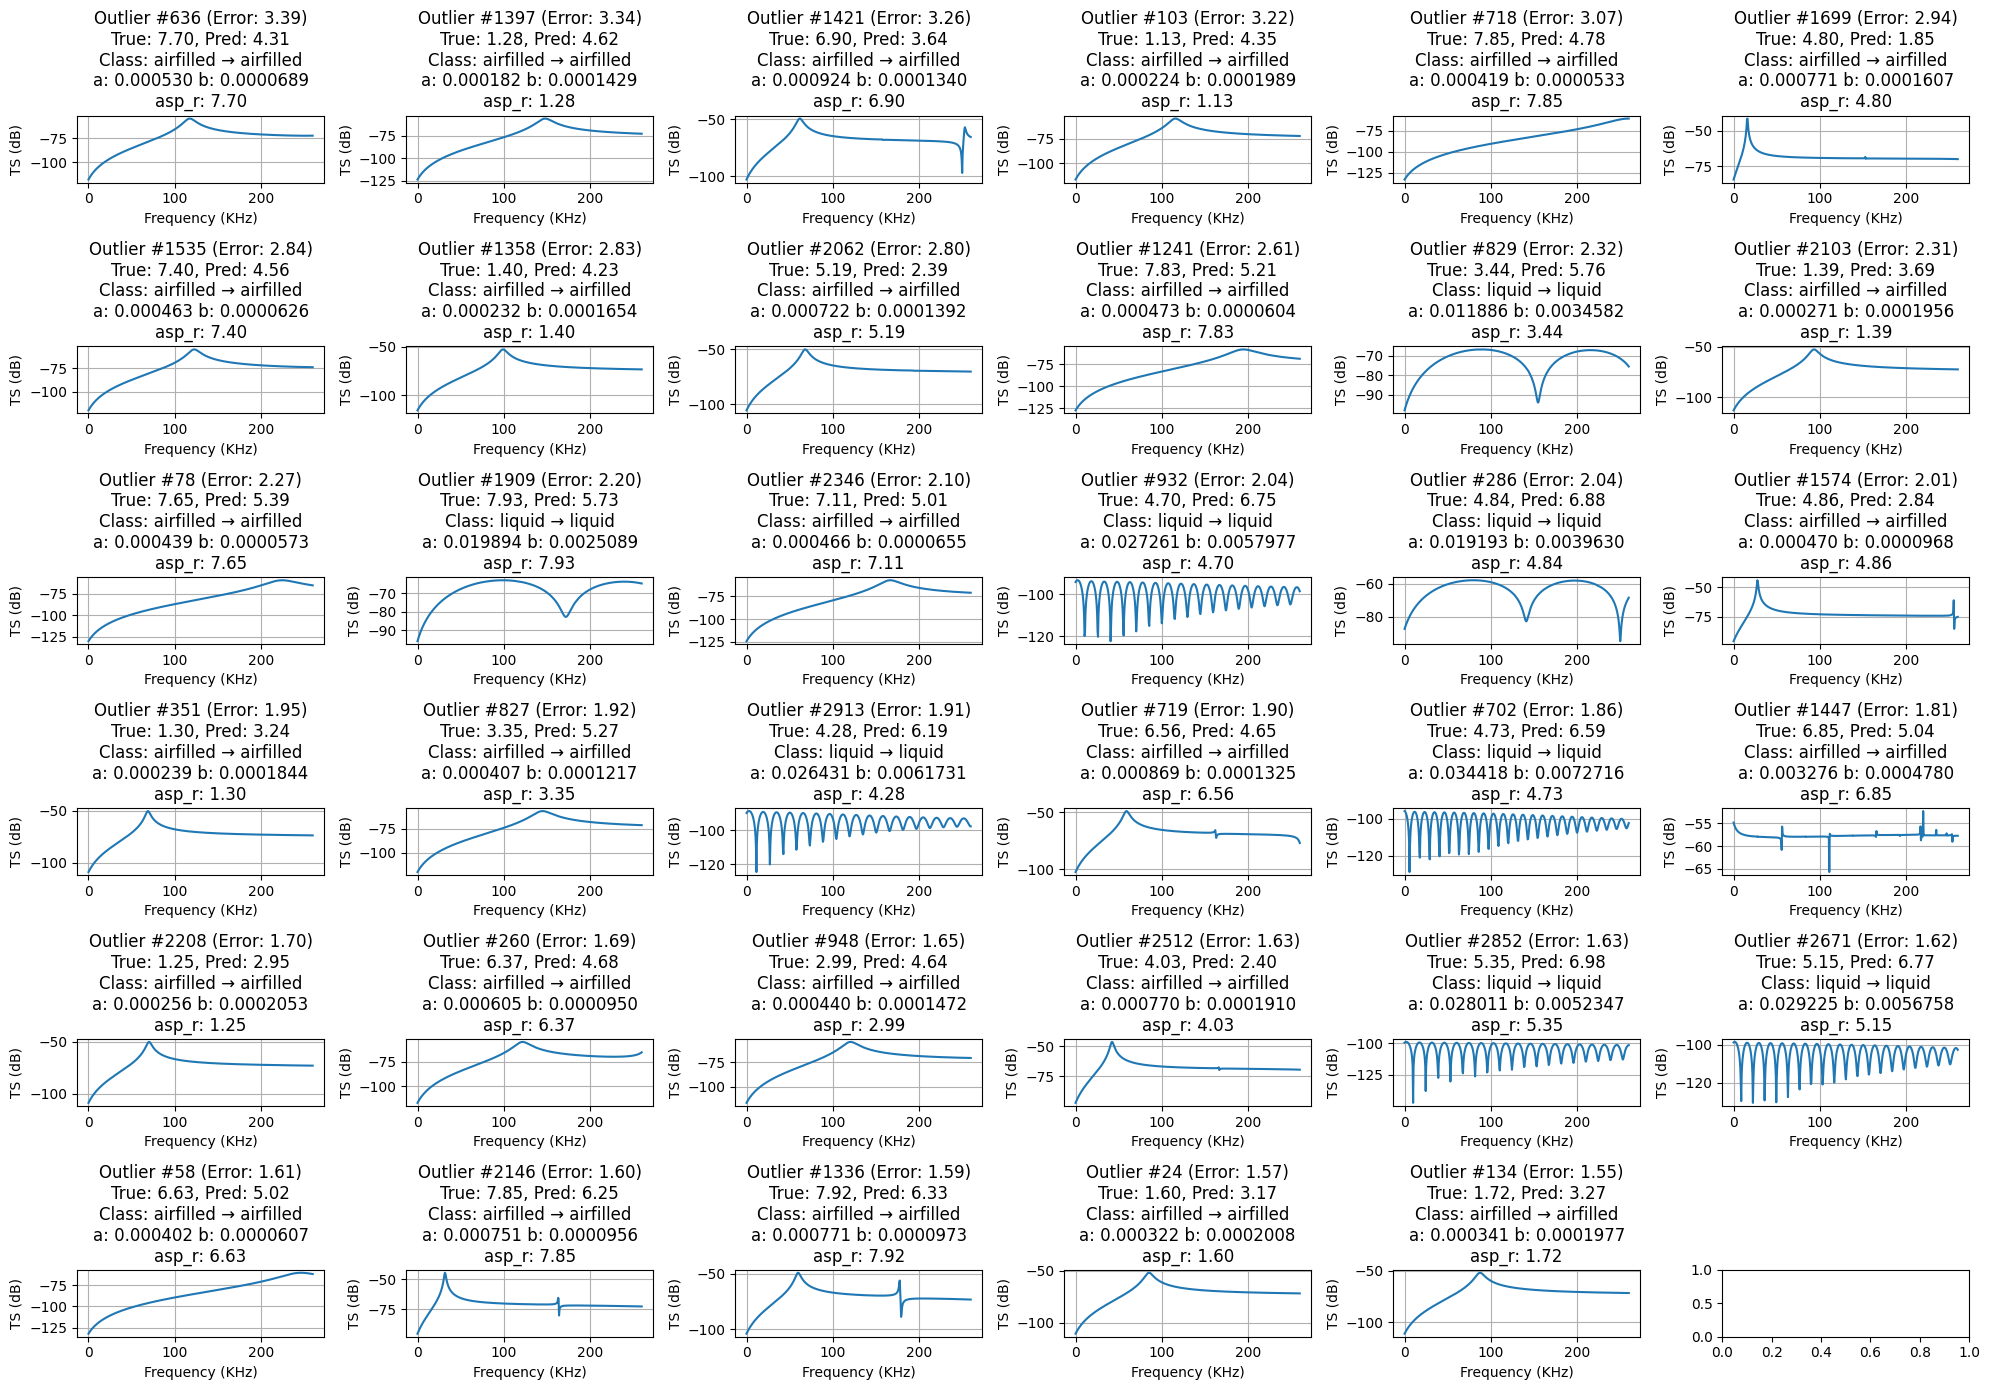

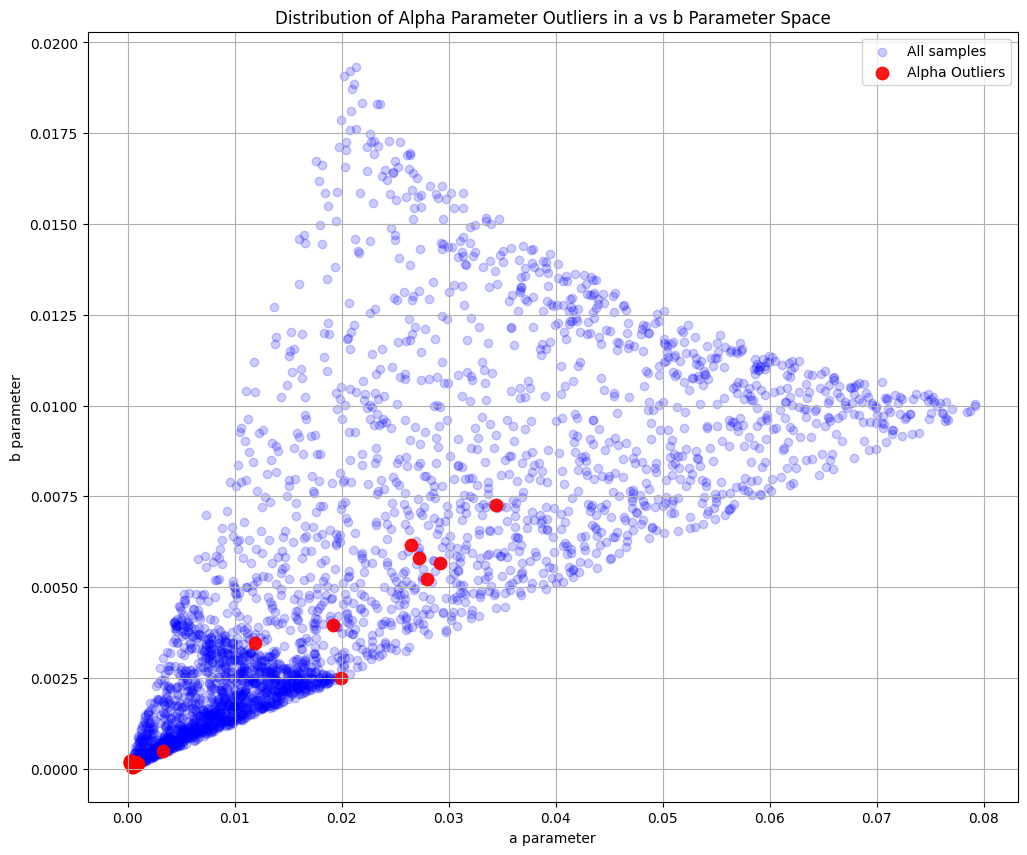

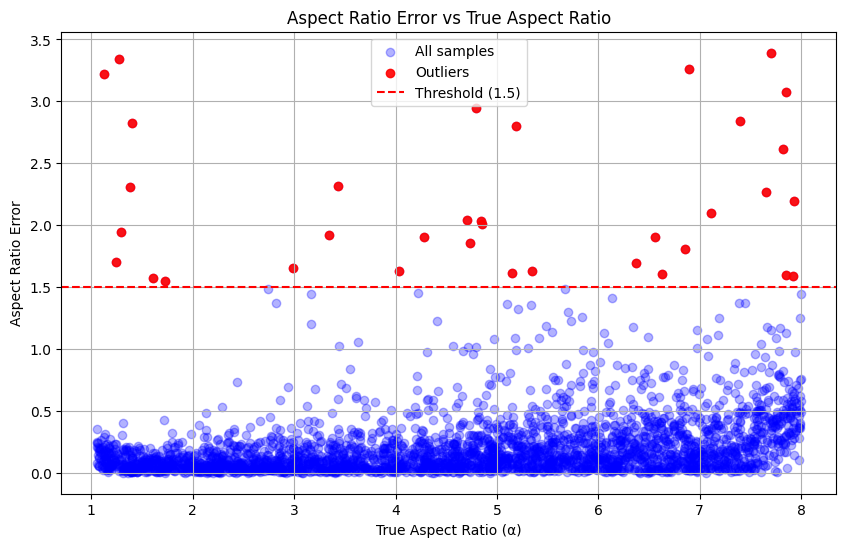


Top 16 worst alpha outliers:
Index | True Class | Pred Class | True Alpha | Pred Alpha | Error
----------------------------------------------------------------------
  636 | airfilled  | airfilled  |       7.70 |       4.31 |  3.39
 1397 | airfilled  | airfilled  |       1.28 |       4.62 |  3.34
 1421 | airfilled  | airfilled  |       6.90 |       3.64 |  3.26
  103 | airfilled  | airfilled  |       1.13 |       4.35 |  3.22
  718 | airfilled  | airfilled  |       7.85 |       4.78 |  3.07
 1699 | airfilled  | airfilled  |       4.80 |       1.85 |  2.94
 1535 | airfilled  | airfilled  |       7.40 |       4.56 |  2.84
 1358 | airfilled  | airfilled  |       1.40 |       4.23 |  2.83
 2062 | airfilled  | airfilled  |       5.19 |       2.39 |  2.80
 1241 | airfilled  | airfilled  |       7.83 |       5.21 |  2.61
  829 | liquid     | liquid     |       3.44 |       5.76 |  2.32
 2103 | airfilled  | airfilled  |       1.39 |       3.69 |  2.31
   78 | airfilled  | airfilled  |       7

In [72]:
def evaluate_predictions_with_alpha_outlier_analysis(model, data_loader, device, label_encoder, reg_train_mean, reg_train_std, X_train_mean, X_train_std, alpha_error_threshold=0.5):
    model.eval()
    all_class_preds = []
    all_class_true = []
    all_reg_preds = []
    all_reg_true = []
    all_input_signals = []
    all_indices = []
    
    idx = 0
    with torch.no_grad():
        for inputs, (class_targets, reg_targets) in data_loader:
            batch_size = inputs.size(0)
            inputs = inputs.to(device)
            class_outputs, reg_outputs = model(inputs)
            
            _, predicted_class = torch.max(class_outputs.data, 1)
            
            all_class_preds.extend(predicted_class.cpu().numpy())
            all_class_true.extend(class_targets.numpy())
            all_reg_preds.extend(reg_outputs.cpu().numpy())
            all_reg_true.extend(reg_targets.numpy())
            all_input_signals.extend(inputs.cpu().numpy())
            all_indices.extend(range(idx, idx + batch_size))
            idx += batch_size
    
    # Convert lists to arrays
    all_class_preds = np.array(all_class_preds)
    all_class_true = np.array(all_class_true)
    all_reg_preds = np.array(all_reg_preds)
    all_reg_true = np.array(all_reg_true)
    all_input_signals = np.array(all_input_signals)
    all_indices = np.array(all_indices)
    
    # Denormalize regression values
    reg_train_mean_subset = reg_train_mean[:3]
    reg_train_std_subset = reg_train_std[:3]
    
    all_reg_preds = all_reg_preds * reg_train_std_subset + reg_train_mean_subset
    all_reg_true = all_reg_true[:, :3] * reg_train_std_subset + reg_train_mean_subset
    
    # Denormalize input signals
    all_input_signals = all_input_signals * X_train_std + X_train_mean
    
    # Get class labels
    class_names = label_encoder.classes_
    true_labels = label_encoder.inverse_transform(all_class_true)
    pred_labels = label_encoder.inverse_transform(all_class_preds)
    
    # ===== ALPHA PARAMETER OUTLIER ANALYSIS =====
    # Calculate predicted and true aspect ratios (alpha = a/b)
    pred_alpha = all_reg_preds[:, 1] / all_reg_preds[:, 2]
    true_alpha = all_reg_true[:, 1] / all_reg_true[:, 2]
    
    # Calculate alpha errors (absolute difference or relative error)
    # Using absolute difference:
    alpha_errors = np.abs(pred_alpha - true_alpha)
    
    # Create mask for outliers
    outlier_mask = alpha_errors > alpha_error_threshold
    outlier_indices = np.where(outlier_mask)[0]
    n_outliers = len(outlier_indices)
    
    print(f"\n===== ALPHA PARAMETER OUTLIER ANALYSIS =====")
    print(f"Found {n_outliers} outliers with alpha error > {alpha_error_threshold} ({n_outliers/len(alpha_errors)*100:.2f}% of samples)")
    
    if n_outliers > 0:
        # Get data for outliers
        outlier_true_labels = true_labels[outlier_indices]
        outlier_pred_labels = pred_labels[outlier_indices]
        outlier_true_alpha = true_alpha[outlier_indices]
        outlier_pred_alpha = pred_alpha[outlier_indices]
        outlier_alpha_errors = alpha_errors[outlier_indices]
        
        outlier_true_a = all_reg_true[outlier_indices, 1]
        outlier_pred_a = all_reg_preds[outlier_indices, 1]
        outlier_true_b = all_reg_true[outlier_indices, 2]
        outlier_pred_b = all_reg_preds[outlier_indices, 2]
        
        outlier_signals = all_input_signals[outlier_indices]
        outlier_original_indices = all_indices[outlier_indices]
        
        # Analyze outlier distribution by class
        class_distribution = {}
        for cls in class_names:
            count = np.sum(outlier_true_labels == cls)
            class_distribution[cls] = count
        
        print("\nOutlier distribution by true class:")
        for cls, count in class_distribution.items():
            print(f"{cls}: {count} outliers ({count/n_outliers*100:.2f}%)")
        
        # Analyze if the outliers are misclassified
        misclassified = outlier_true_labels != outlier_pred_labels
        print(f"\nMisclassification analysis:")
        print(f"Number of outliers that are also misclassified: {np.sum(misclassified)} ({np.sum(misclassified)/n_outliers*100:.2f}%)")
        
        # Sort outliers by error magnitude (descending)
        sorted_idx = np.argsort(outlier_alpha_errors)[::-1]
        
        # Extract data for the top outliers
        max_outliers_to_visualize = min(36, n_outliers)
        top_outliers_idx = sorted_idx[:max_outliers_to_visualize]
        
        # Frequency domain visualization
        fig, axs = plt.subplots(6, 6, figsize=(20, 14))
        axs = axs.flatten()
        
        for i in range(max_outliers_to_visualize):
            idx = top_outliers_idx[i]
            original_idx = outlier_original_indices[idx]
            signal = outlier_signals[idx].squeeze()  # Remove channel dimension
            
            ax = axs[i]
            # Plot the frequency domain signal
            ax.plot(np.arange(0, 260, 260/len(signal)), signal)
            
            true_a = outlier_true_a[idx]
            pred_a = outlier_pred_a[idx]
            true_b = outlier_true_b[idx]
            pred_b = outlier_pred_b[idx]
            true_asp = outlier_true_alpha[idx]
            pred_asp = outlier_pred_alpha[idx]
            true_class = outlier_true_labels[idx]
            pred_class = outlier_pred_labels[idx]
            
            ax.set_title(f"Outlier #{original_idx} (Error: {outlier_alpha_errors[idx]:.2f})\n"
                         f"True: {true_asp:.2f}, Pred: {pred_asp:.2f}\n"
                         f"Class: {true_class} → {pred_class}\n"
                         f"a: {true_a:.6f} b: {true_b:.7f}\n"
                         f"asp_r: {true_asp:.2f}")
                        
            ax.set_xlabel('Frequency (KHz)')
            ax.set_ylabel('TS (dB)')
            ax.grid(True)
        
        plt.tight_layout()
        #plt.savefig("alpha_outliers_freq_domain.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # === 2D PARAMETER VISUALIZATION (a vs b) ===
        plt.figure(figsize=(12, 10))
        
        # Plot all points with lower opacity
        plt.scatter(
            all_reg_true[:, 1],  # a parameter
            all_reg_true[:, 2],  # b parameter
            c='blue',
            alpha=0.2,
            label='All samples'
        )
        
        # Plot outliers with higher opacity and red color
        scatter = plt.scatter(
            all_reg_true[outlier_indices, 1],  # a parameter for outliers
            all_reg_true[outlier_indices, 2],  # b parameter for outliers
            c='red',
            s=80,                              # larger point size
            alpha=0.9,
            label='Alpha Outliers'
        )
         
        plt.xlabel('a parameter')
        plt.ylabel('b parameter')
        plt.title('Distribution of Alpha Parameter Outliers in a vs b Parameter Space')
        plt.legend()
        plt.grid(True)
        #plt.savefig("alpha_outliers_parameter_space.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create a 2D scatter plot of true alpha vs alpha error
        plt.figure(figsize=(10, 6))
        plt.scatter(true_alpha, alpha_errors, alpha=0.3, c='blue', label='All samples')
        plt.scatter(outlier_true_alpha, outlier_alpha_errors, alpha=0.9, c='red', label='Outliers')
        plt.axhline(y=alpha_error_threshold, color='r', linestyle='--', label=f'Threshold ({alpha_error_threshold})')
        plt.xlabel('True Aspect Ratio (α)')
        plt.ylabel('Aspect Ratio Error')
        plt.title('Aspect Ratio Error vs True Aspect Ratio')
        plt.legend()
        plt.grid(True)
        #plt.savefig("alpha_errors_vs_true_alpha.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Table of top outliers
        if n_outliers >= 16:
            top_indices = sorted_idx[:16]
            
            print("\nTop 16 worst alpha outliers:")
            print("Index | True Class | Pred Class | True Alpha | Pred Alpha | Error")
            print("-" * 70)
            
            for i, idx in enumerate(top_indices):
                orig_idx = outlier_original_indices[idx]
                print(f"{orig_idx:5d} | {outlier_true_labels[idx]:10s} | {outlier_pred_labels[idx]:10s} | "
                      f"{outlier_true_alpha[idx]:10.2f} | {outlier_pred_alpha[idx]:10.2f} | {outlier_alpha_errors[idx]:5.2f}")
    
    return {
        'classification': {
            'true': true_labels,
            'pred': pred_labels,
        },
        'regression': {
            'true': all_reg_true,
            'pred': all_reg_preds,
        },
        'alpha_outliers': {
            'indices': outlier_original_indices if n_outliers > 0 else [],
            'true_labels': outlier_true_labels if n_outliers > 0 else [],
            'pred_labels': outlier_pred_labels if n_outliers > 0 else [],
            'true_alpha': outlier_true_alpha if n_outliers > 0 else [],
            'pred_alpha': outlier_pred_alpha if n_outliers > 0 else [],
            'errors': outlier_alpha_errors if n_outliers > 0 else [],
            'threshold': alpha_error_threshold
        }
    }

# Usage example:
alpha_metrics = evaluate_predictions_with_alpha_outlier_analysis(
    model, 
    test_loader, 
    device, 
    label_encoder, 
    reg_train_mean, 
    reg_train_std,
    X_train_mean,
    X_train_std,
    alpha_error_threshold=1.5  # Start with this threshold and adjust based on results
)


===== ALPHA PARAMETER OUTLIER VISUALIZATION BY CLASS =====
Found 35 outliers with alpha error > 1.50 (1.17% of samples)
airfilled: 27 outliers (77.14%)
liquid: 8 outliers (22.86%)


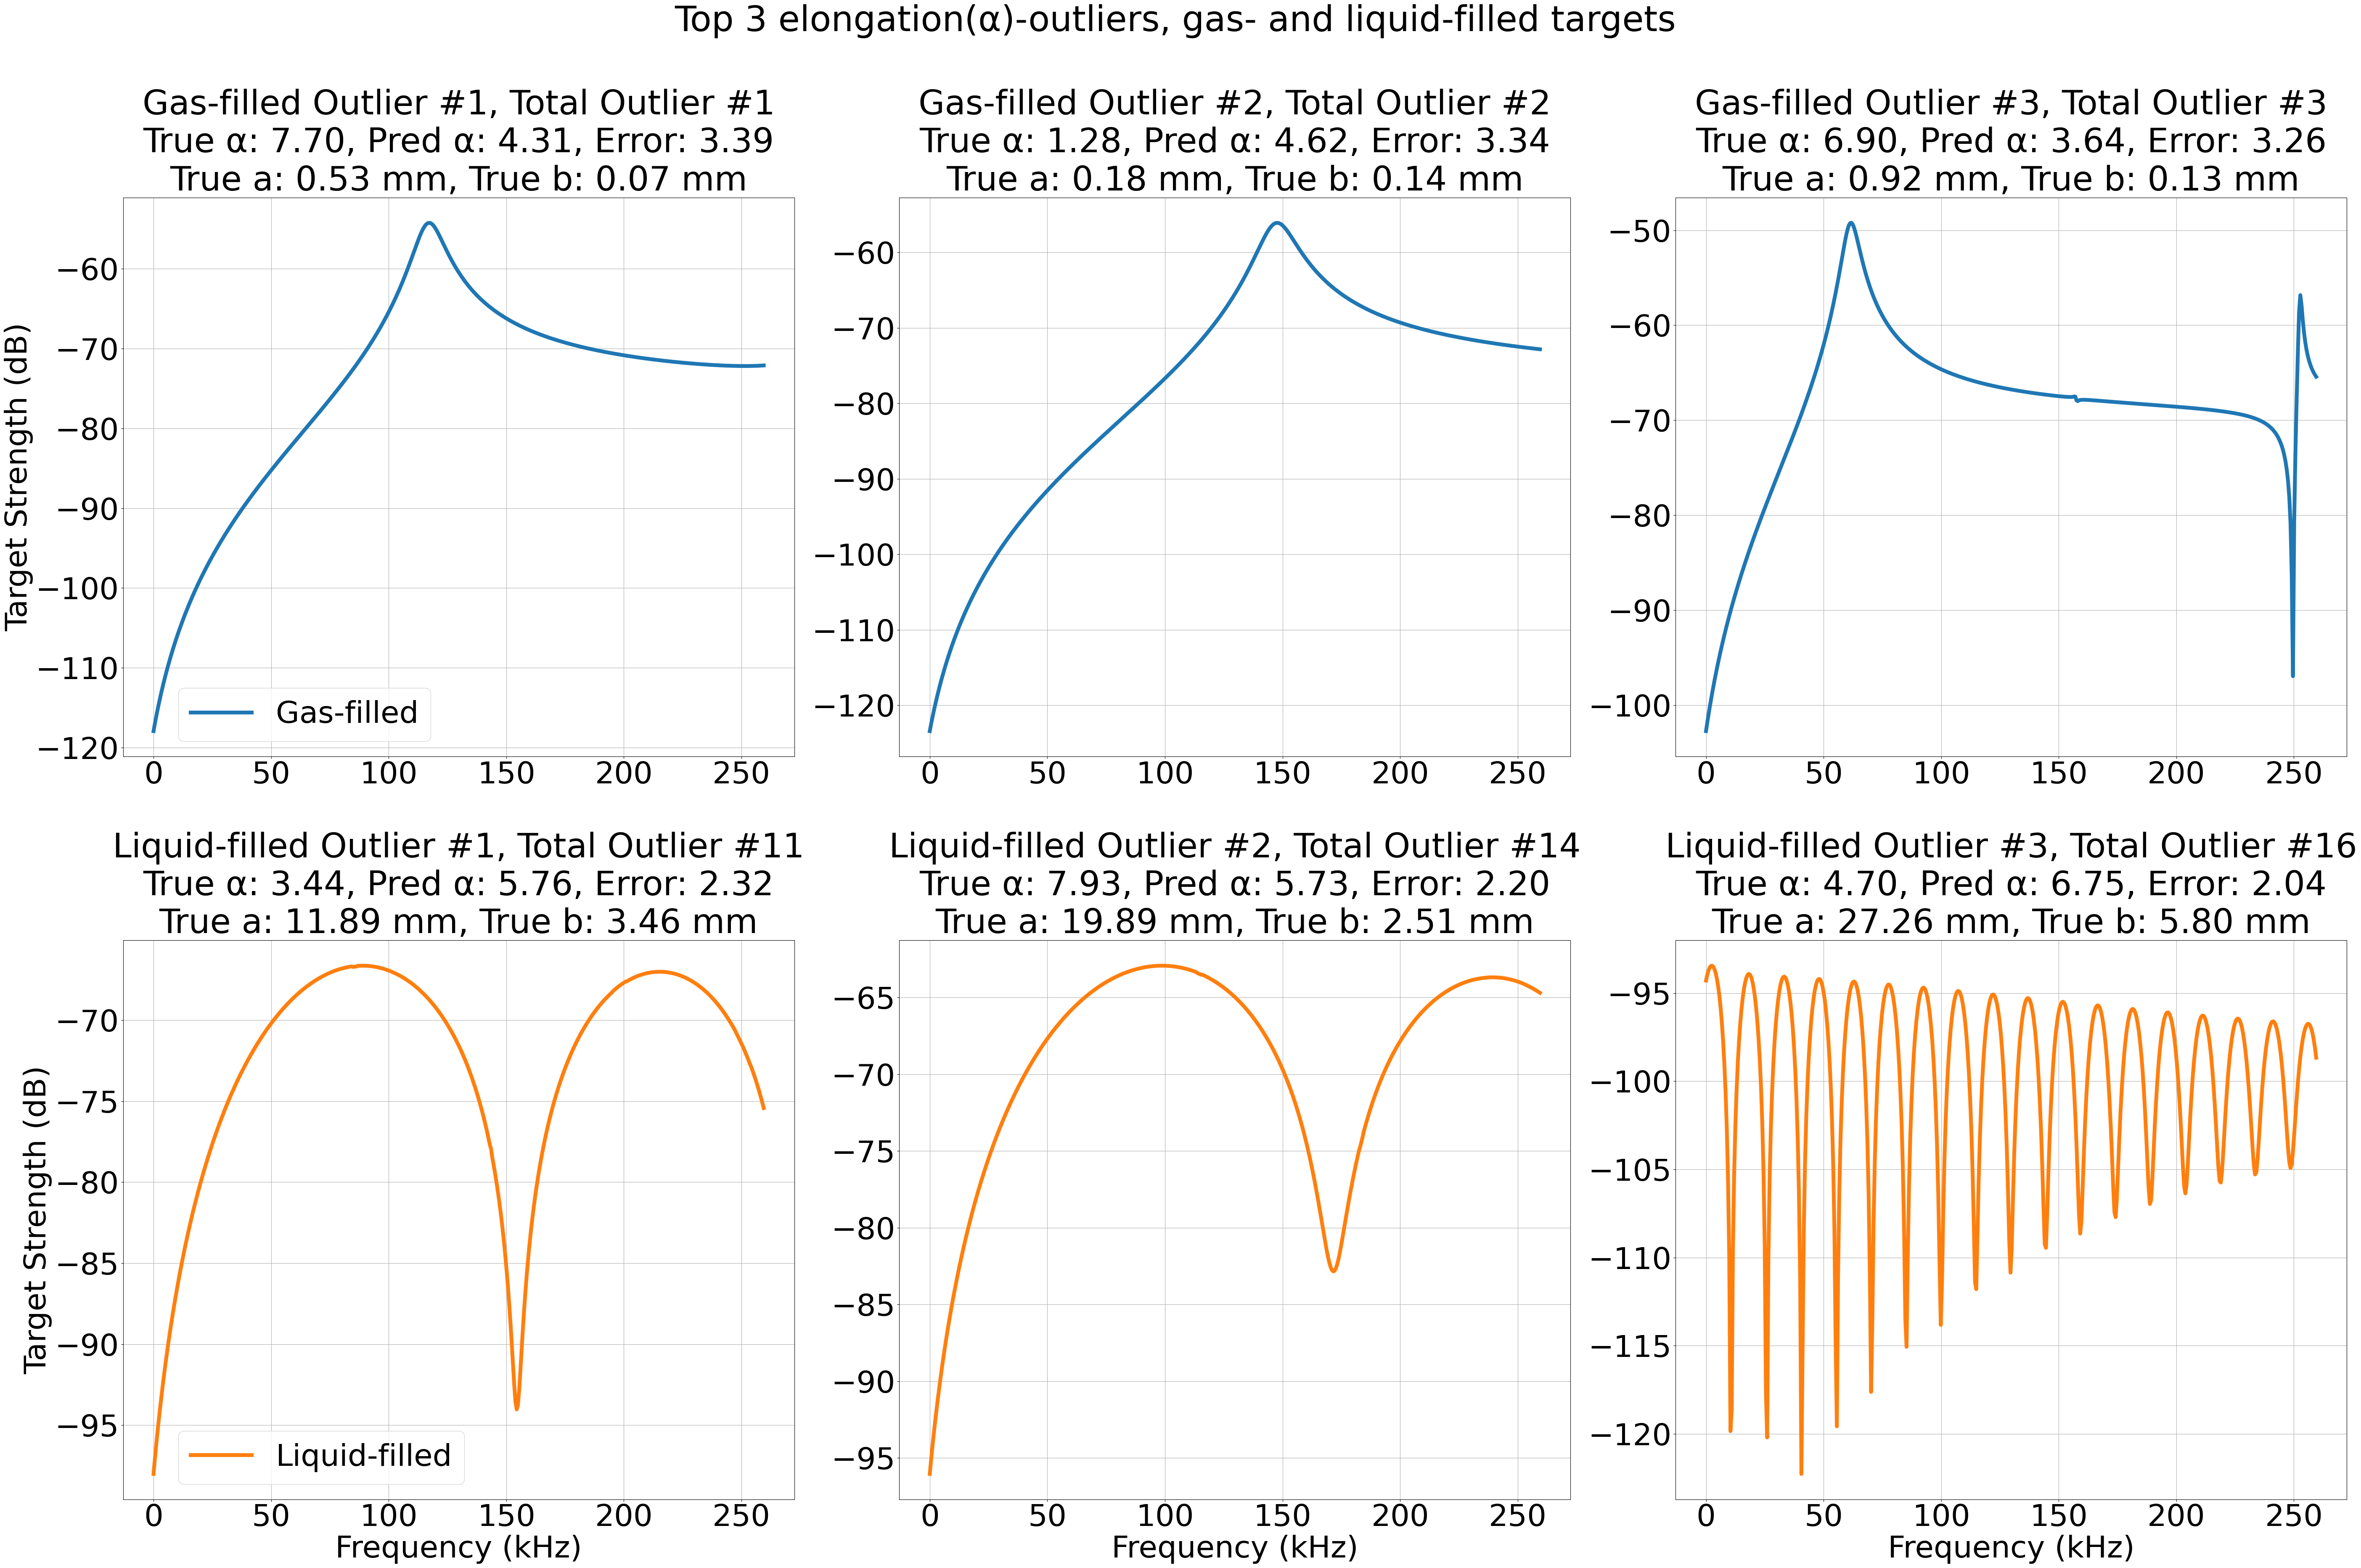

In [ ]:
def visualize_top_alpha_outliers_by_class(model, data_loader, device, label_encoder, reg_train_mean, reg_train_std, 
                                X_train_mean, X_train_std, alpha_error_threshold=1.5, top_n=3):
    """
    Visualize the top N outliers for each class based on alpha (aspect ratio) error magnitude.
    
    Args:
        model: Trained model
        data_loader: Data loader for test set
        device: Device to run evaluation on
        label_encoder: Label encoder for classification
        reg_train_mean, reg_train_std: Normalization parameters for regression
        X_train_mean, X_train_std: Normalization parameters for input signals
        alpha_error_threshold: Threshold for defining alpha outliers
        top_n: Number of top outliers to visualize per class
    """
    model.eval()
    all_class_preds = []
    all_class_true = []
    all_reg_preds = []
    all_reg_true = []
    all_input_signals = []
    all_indices = []
    
    idx = 0
    with torch.no_grad():
        for inputs, (class_targets, reg_targets) in data_loader:
            batch_size = inputs.size(0)
            inputs = inputs.to(device)
            class_outputs, reg_outputs = model(inputs)
            
            _, predicted_class = torch.max(class_outputs.data, 1)
            
            all_class_preds.extend(predicted_class.cpu().numpy())
            all_class_true.extend(class_targets.numpy())
            all_reg_preds.extend(reg_outputs.cpu().numpy())
            all_reg_true.extend(reg_targets.numpy())
            all_input_signals.extend(inputs.cpu().numpy())
            all_indices.extend(range(idx, idx + batch_size))
            idx += batch_size
    
    # Convert lists to arrays
    all_class_preds = np.array(all_class_preds)
    all_class_true = np.array(all_class_true)
    all_reg_preds = np.array(all_reg_preds)
    all_reg_true = np.array(all_reg_true)
    all_input_signals = np.array(all_input_signals)
    all_indices = np.array(all_indices)
    
    # Denormalize regression values
    reg_train_mean_subset = reg_train_mean[:3]
    reg_train_std_subset = reg_train_std[:3]
    
    all_reg_preds = all_reg_preds * reg_train_std_subset + reg_train_mean_subset
    all_reg_true = all_reg_true[:, :3] * reg_train_std_subset + reg_train_mean_subset
    
    # Denormalize input signals
    all_input_signals = all_input_signals * X_train_std + X_train_mean
    
    # Get class labels
    class_names = label_encoder.classes_
    true_labels = label_encoder.inverse_transform(all_class_true)
    pred_labels = label_encoder.inverse_transform(all_class_preds)
    
    # ===== ALPHA PARAMETER OUTLIER ANALYSIS =====
    # Calculate predicted and true aspect ratios (alpha = a/b)
    pred_alpha = all_reg_preds[:, 1] / all_reg_preds[:, 2]
    true_alpha = all_reg_true[:, 1] / all_reg_true[:, 2]
    
    # Calculate alpha errors (absolute difference)
    alpha_errors = np.abs(pred_alpha - true_alpha)
    
    # Create mask for outliers
    outlier_mask = alpha_errors > alpha_error_threshold
    outlier_indices = np.where(outlier_mask)[0]
    n_outliers = len(outlier_indices)
    
    print(f"\n===== ALPHA PARAMETER OUTLIER VISUALIZATION BY CLASS =====")
    print(f"Found {n_outliers} outliers with alpha error > {alpha_error_threshold:.2f} ({n_outliers/len(alpha_errors)*100:.2f}% of samples)")
    
    if n_outliers > 0:
        # Get data for outliers
        outlier_true_labels = true_labels[outlier_indices]
        outlier_pred_labels = pred_labels[outlier_indices]
        outlier_true_alpha = true_alpha[outlier_indices]
        outlier_pred_alpha = pred_alpha[outlier_indices]
        outlier_alpha_errors = alpha_errors[outlier_indices]
        
        outlier_true_a = all_reg_true[outlier_indices, 1]
        outlier_pred_a = all_reg_preds[outlier_indices, 1]
        outlier_true_b = all_reg_true[outlier_indices, 2]
        outlier_pred_b = all_reg_preds[outlier_indices, 2]
        
        outlier_signals = all_input_signals[outlier_indices]
        outlier_original_indices = all_indices[outlier_indices]
        
        # Analyze outlier distribution by class
        class_distribution = {}
        for cls in class_names:
            class_mask = outlier_true_labels == cls
            class_indices = np.where(class_mask)[0]
            count = len(class_indices)
            class_distribution[cls] = count
            
            print(f"{cls}: {count} outliers ({count/n_outliers*100:.2f}%)")
        


        global_sorted_idx = np.argsort(outlier_alpha_errors)[::-1]

        # Separate outliers by class
        class_outlier_indices = {}
        for cls in class_names:
            class_mask = outlier_true_labels == cls
            class_indices = np.where(class_mask)[0]
            
            if len(class_indices) > 0:
                # Sort by alpha error magnitude (descending)
                class_sorted_idx = class_indices[np.argsort(outlier_alpha_errors[class_indices])[::-1]]
                class_outlier_indices[cls] = class_sorted_idx[:min(top_n, len(class_sorted_idx))]
            else:
                class_outlier_indices[cls] = []
        
        # Create figure with top N outliers for each class
        n_classes = len(class_names)
        fig, axs = plt.subplots(n_classes, top_n, figsize=(56, 19 * n_classes))
        fig.suptitle('Top 3 elongation(α)-outliers, gas- and liquid-filled targets', fontsize=60)
        
        # Handle case with only one class (make sure axs is 2D)
        if n_classes == 1:
            axs = np.array([axs])
        
        for i, cls in enumerate(class_names):
            class_top_indices = class_outlier_indices[cls]
            for j in range(top_n):
                ax = axs[i, j]
                
                if j < len(class_top_indices):  # Ensure we don't exceed the available outliers
                    idx = class_top_indices[j]
                    original_idx = outlier_original_indices[idx]
                    signal = outlier_signals[idx].squeeze()
                    
                    
                    
                    # Plot the frequency domain signal with class-specific colors
                    if cls == 'airfilled':
                        ax.plot(np.arange(0, 260, 260/len(signal)),
                                 signal, linewidth=6.5, color='tab:blue', label = 'Gas-filled')
                        name = 'Gas-filled'                        
                    else:  # liquid
                        ax.plot(np.arange(0, 260, 260/len(signal)),
                                 signal, linewidth=6.5, color='tab:orange', label = "Liquid-filled")
                        name = 'Liquid-filled'
                        


                    true_alpha = outlier_true_alpha[idx]
                    pred_alpha = outlier_pred_alpha[idx]
                    true_a = outlier_true_a[idx]
                    pred_a = outlier_pred_a[idx]
                    true_b = outlier_true_b[idx]
                    pred_b = outlier_pred_b[idx]
                    
                    global_rank = np.where(global_sorted_idx == idx)[0][0] + 1  # +1 for 1-based indexing

                    # Get theta values for this outlier
                    true_theta = all_reg_true[outlier_indices[idx], 0]
                    pred_theta = all_reg_preds[outlier_indices[idx], 0]
                    
                    ax.set_title(f"\n{name} Outlier #{j+1}, Total Outlier #{global_rank}\n"
                                f"True α: {true_alpha:.2f}, Pred α: {pred_alpha:.2f}, Error: {outlier_alpha_errors[idx]:.2f}\n"
                                f"True a: {true_a*1000:.2f} mm, True b: {true_b*1000:.2f} mm", fontsize = 58)
                    if j == 0:
                        ax.set_ylabel('Target Strength (dB)', fontsize = 52)
                        ax.legend(loc='lower left', fontsize=52, framealpha = 0.8, bbox_to_anchor=(0.06, 0))

                    if cls == 'liquid':
                        
                        ax.set_xlabel('Frequency (kHz)', fontsize = 52)
                    
                    ax.tick_params(axis='both', which='major', labelsize=52)
                    ax.grid(True)
                else:
                    # If we have fewer than top_n outliers for this class, leave the plot empty
                    ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.98], w_pad=3.0, h_pad=0.7)
        
        #plt.savefig('../Figures/top_alpha_outliers_by_class.png', dpi=600, bbox_inches='tight')
        plt.savefig('../Figures/top_alpha_outliers_by_class_low.png', dpi=100, bbox_inches='tight')

        plt.show()

        
        return {
            'class_outlier_indices': class_outlier_indices,
            'outlier_indices': outlier_indices,
            'outlier_true_labels': outlier_true_labels,
            'outlier_true_alpha': outlier_true_alpha,
            'outlier_pred_alpha': outlier_pred_alpha,
            'outlier_alpha_errors': outlier_alpha_errors
        }
    
    return None

# Usage example:
alpha_outlier_vis = visualize_top_alpha_outliers_by_class(
    model, 
    test_loader, 
    device, 
    label_encoder, 
    reg_train_mean, 
    reg_train_std,
    X_train_mean,
    X_train_std,
    alpha_error_threshold=1.5,
    top_n=3
)